# Analysis of communities and sentiments for Game of Thrones characters
This notebook holds all the results of the analysis answering the following research question:
- Are the characters in the Game of Thrones series generally more connected to their house, religion, culture, or external characters and is there a similarity between the average sentiment of a house/religion/culture and the average sentiment of the houses/religions/cultures that they are most connected to?

The analysis is based on data obatained from the Game of Thrones site on [Fandom.com](https://gameofthrones.fandom.com/wiki/Game_of_Thrones) and the wiki pages for each of the characters. We create a graph by linking the characters based on the links between the characters on the wiki pages and analyse the sentiments of the character's wiki pages using the  [labMT](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) wordlist. 
## Imports

In [83]:
import pandas as pd
import networkx as nx
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import nltk
import requests
import community
import json

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import linregress

from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS

## Helper functions
We have implemented some helper functions that will be used later in the notebook.

The following function returns the sentiment of a given text

In [84]:
def get_sentiments(text, dict_avg_sentiments):
    text_tokens = word_tokenize(text)
    text_words = [w.lower() for w in text_tokens if w.isalpha()]
    fdist = FreqDist(text_words)
    total_count = 0
    sentiment = 0
    for w in fdist:
        if w in dict_avg_sentiments:
            sentiment += dict_avg_sentiments[w]*fdist[w]
            total_count += fdist[w]
    if total_count == 0:
        return 0
    sentiment /= total_count
    return sentiment

The following functions get the TFTR scores of a two given texts as was introduced in week 7. Since the two input texts can be of different lengths, we have included an option to weight the scores by the length of the texts. We have also included an option to only look at the words that are in the labMT word list.

In [85]:
def get_TFTR(text1, text2, c = 1, weighted = False, sentiment_words=None):

    stopwords = nltk.corpus.stopwords.words('english')

    text1_tokens = word_tokenize(text1)
    text1_words = [w.lower() for w in text1_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]

    text2_tokens = word_tokenize(text2)
    text2_words = [w.lower() for w in text2_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]
    
    if sentiment_words is not None:
        text1_words = [w for w in text1_words if w in sentiment_words]
        text2_words = [w for w in text2_words if w in sentiment_words]
        
    if weighted:
        r1 = len(text2_words)/len(text1_words)
        r2 = len(text1_words)/len(text2_words)
        if r1 > r2:
            r1 = 1
        else:
            r2 = 1
    else:
        r1 = 1
        r2 = 1

    fdist1 = FreqDist(text1_words)
    fdist2 = FreqDist(text2_words)

    dict1_TFTR = dict()
    dict2_TFTR = dict()

    for w in fdist1:
        if w in fdist2:
            weight1 = fdist1[w]*r1/(fdist2[w]*r2+c)
        else:
            weight1 = fdist1[w]*r1/c
        dict1_TFTR[w] = weight1*fdist1[w]*r1
        
    for w in fdist2:
        if w in fdist1:
            weight2 = fdist2[w]*r2/(fdist1[w]*r1+c)
        else:
            weight2 = fdist2[w]*r2/c
        dict2_TFTR[w] = weight2*fdist2[w]*r2

    dict1_TFTR = dict(sorted(dict1_TFTR.items(), key=lambda x:x[1], reverse=True))
    dict2_TFTR = dict(sorted(dict2_TFTR.items(), key=lambda x:x[1], reverse=True))

    return dict1_TFTR, dict2_TFTR, fdist1, fdist2


Depending on the parameters main_house_analysis, the following function either returns all the character the input character is connected to or only all the charcters it is connected to excluding all the characters that belong to the house, religion or culture, depening on the attribute_type. 

In [86]:
def connected_character(node_name, graph, attribute_type, main_house_analysis=False):
    # Select a node
    successors = graph.successors(node_name)
    predecessors = graph.predecessors(node_name)
    linked_nodes = set(successors) | set(predecessors)

    if main_house_analysis:
        return linked_nodes

    # Get houses/religion/culture the character is a part of
    node_attribute = graph.nodes(data=True)[node_name][attribute_type]
    if attribute_type == 'houses':
        node_attributes = node_attribute.split(', ')

    # Remove all the nodes that are a part of the same house/religion/culture
    filtered_nodes = []
    for node in linked_nodes:
        destination_attribute = graph.nodes[node].get(attribute_type)
        checker = True
        if attribute_type == 'houses':
            destination_attributes = destination_attribute.split(', ')
            
            for destination_attribute in destination_attributes:
                if destination_attribute in node_attributes:
                    checker = False
        else:
            if destination_attribute == node_attribute:
                checker = False

        if checker:
            filtered_nodes.append(node)
    
    return filtered_nodes

The following function returns all the characters that are connected to a character with the given house/religion/culture, including repetitions, if the same character is connected to multiple characters with the given house/religion/culture.

In [87]:
def get_connected_to_attribute(attribute, graph, attribute_type):
    connected_to_attribute = []

    # Get all the characters from the desired house/religion/culture
    nodes_with_attribute = [node for node, data in graph.nodes(data=True) if attribute in data.get(attribute_type)]
    for ch in nodes_with_attribute:
        connected_to_attribute.extend(connected_character(ch, graph, attribute_type))

    return(connected_to_attribute)

The following function returns the frequency of the attributes in attribute_list for all the characters in the character_list.

In [88]:
def count_connection_to_attribute(character_list, graph, attribute_type, attribute_list):
    attribute_of_character_list = []
    connected_attributes_freq = {}

    for character in character_list:
        if attribute_type == 'houses':
            node_data = graph.nodes(data=True)[character][attribute_type].split(', ')
            attribute_of_character_list.extend(node_data)
        else:
            node_data = graph.nodes(data=True)[character][attribute_type]
            attribute_of_character_list.append(node_data)

    for att in attribute_list:
        connected_attributes_freq[att] = attribute_of_character_list.count(att)

    return dict(sorted(connected_attributes_freq.items(), key=lambda x: x[1], reverse=True))

The following function returns the number of links between all the characters in the input house/religion/culture and all other houses/religions/cultures.

In [89]:
def freq_connected_attribute_to(attribute, G, attribute_type, attribute_list):
    s1 = get_connected_to_attribute(attribute, G, attribute_type)
    s2 = count_connection_to_attribute(s1, G, attribute_type=attribute_type, attribute_list=attribute_list)
    return s2

The following function returns the main house of a character

In [90]:
def main_house(character, graph, houses_list):
    filtered_most_connected_houses = {}
    cc = connected_character(character, graph, attribute_type='houses', main_house_analysis=True)

    node_houses = graph.nodes(data=True)[character]['houses']
    node_houses = node_houses.split(', ')
    most_connected_houses = count_connection_to_attribute(character_list=cc, graph=graph, attribute_type='houses', attribute_list=houses_list)

    for house in most_connected_houses:
        if house in node_houses:
            filtered_most_connected_houses[house] = most_connected_houses[house]

    return max(filtered_most_connected_houses)

The following function calculates a difference mesure for average sentiments of the houses/religions/cultures and the average sentiments of the houses/religions/cultures that they are most connected to.

In [91]:
def sentiment_difference(G,attribute):
    edges = G.edges(attribute)
    avg_diff = 0
    for edge in edges:
        node1 = edge[0]
        node2 = edge[1]
        sentiment1 = G.nodes[node1]['sentiment']
        sentiment2 = G.nodes[node2]['sentiment']
        diff = np.abs(sentiment1 - sentiment2)
        weight = G.edges[edge]['weight']
        avg_diff += diff*weight
    avg_diff /= len(edges)
    return avg_diff

## Loading the data
In the following cell, we load the data using the Game of Thrones Fandom API using requests and regular expressions. To avoid having to load the data every time we run the notebook, we save all the wiki pages for each character as .txt files. We also save lists containing the houses, religons and cultures as .csv and finaly a .json file containing all the characters and their attributes.
The next time the cell is run, all the data will be loaded from the files.

To download the data, we used the Fandom API. Fandom.com provides an API that makes it possible to get the text from each page.
The most important parameters of the API for our purposes were: action, prop, rvprop, format, and titles. The first four of these parameters consistently maintain the same values, while the titles parameter dictates which page is to be downloaded.

"action": "query", \
"prop": "revisions", \
"rvprop": "content", \
"format": "JSON", \
"titles": ""

The front page, of the Game of Thrones wiki, is a long document listing all the houses and the cast that played each character. Therefore, our initial step is getting this page by setting titles to "Game_of_Thrones".

The API response is a JSON with key-value pairs. Specifically, the key contains some keys, which contain other keys forming a nested structure. To get the text out we need the following for the response:
response['query']['pages'][page_id]['revisions'][0]['*']


#### Analyzing the data
The result is a text document that can be stored and analyzed. Notably, hyperlinks are formatted as [[title|hyperlink]] or just [[hyperlink]] and headings formatted as ===name of heading===. This makes it possible for us to process the data in a highly automatic fashion. 


The lines of interest are the ones that start with a *. The part of the line that is of interest contains the character which is always after the word “as”. The document contains far more information than the cast, so we remove everything outside ===cast===, down to ===crew===. 


#### Processing the data

We split the text piece into individual lines and removed the ones that did not start with “*”. We also removed the part of the line before “as”. This ensured we could work on a per-line basis and that there was only one hyperlink in each line. 

Afterward, we used Regular Expressions, to extract the character from the text. Regular Expression will from now on be referred to as regex. Regex needs a pattern to match the text. This is where the standardized way the document is written in, explained in the analysis, comes in handy. Since the characters are written as a hyperlink, regex can be used to find hyperlinks with the pattern, r’\[{2}(.+?)\]{2}. 

This pattern says, find two opening square brackets, and return everything until two closing square brackets. 

In the cases where the hyperlinks were written as [[title|hyperlink]], we split the string into two parts, by the | and only extracted the first part. Two titles caused us problems, Archmeister Ebrose and Khal Drogo. Why? So, we just manually replaced these with Ebrose and Drogo. By saving all of these titles in a list, we can get the wiki page associated with each character by looping over the list with the \autoref{api call}, as well as building a network with titles as nodes. 


In [92]:
if (not os.path.exists('files/names.csv')) or (not os.path.exists('files/houses.csv')) or (not os.path.exists('files/cultures.csv')) or (not os.path.exists('files/religions.csv')) or (not os.path.exists('files/wiki_texts/')) or (not os.path.exists('files/characters.json')):
    # create paths
    if not os.path.exists('files'):
        os.mkdir('files')
    if not os.path.exists('files/wiki_texts'):
        os.mkdir('files/wiki_texts')

    baseurl = "https://gameofthrones.fandom.com/api.php?"

    pattern = r'\[{2}(.+?)\]{2}'
    word_pattern = r'\b\w+\b'

    site = 'Game_of_Thrones'
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": site
    }

    # Send the API request to retrieve the content
    response = requests.get(baseurl, params=params)
    data = response.json()

    # Extract the text content
    page_id = list(data['query']['pages'].keys())[0]
    text_content = data['query']['pages'][page_id]['revisions'][0]['*']

    cast = text_content[text_content.find("==Cast=="):text_content.find("==Crew==")]

    # find all lines starting with *
    lines = cast.split('\n')
    lines = [line for line in lines if line.startswith('*')]
    lines_chars = [line[line.find("as "):] for line in lines]
    # extract the names
    pattern = r'\[{2}(.+?)\]{2}'
    names = [re.findall(pattern, line)[0] for line in lines_chars]
    names = [name.split('|')[0] for name in names]

    names.remove('Archmaester')
    names.append('Ebrose')
    names.remove('Khal')
    names.append('Drogo')

    # save names to csv
    names_df = pd.DataFrame(names, columns=['Name'])
    names_df.to_csv('files/names.csv', index=False)


    characters = {}
    houses_list = []
    religions_list = []
    cultures_list = []

    for name in names:
        print(name)
        params = {
            "action": "query",
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "titles": name
        }

        # Send the API request to retrieve the content
        response = requests.get(baseurl, params=params)
        data = response.json()

        # Extract the text content
        page_id = list(data['query']['pages'].keys())[0]
        text_content = data['query']['pages'][page_id]['revisions'][0]['*']
        
        # save text content to text file
        with open('files/wiki_texts/' + name + '.txt', 'w') as f:
            f.write(text_content)

        # find line with | House
        try:
            house_line = re.findall(r'\| House (.+)', text_content)[0]
            houses = re.findall(pattern, house_line)
            if len(houses) == 0:
                houses = ['No house']
        except:
            houses = ['No house']


        culture_line = re.findall(r'\| Culture (.+)', text_content)[0]
        culture = re.findall(pattern, culture_line)
        try:
            culture = culture[0].split('|')[0]
        except:
            culture = 'No culture'

        if culture not in cultures_list:
            cultures_list.append(culture)
            
        religion_line = re.findall(r'\| Religion (.+)', text_content)[0]
        religion = re.findall(pattern, religion_line)
        try:
            religion = religion[0].split('|')[0]
        except:
            religion = 'No religion'

        if religion not in religions_list:
            religions_list.append(religion)


        num_episodes = re.findall(r'\| Appearances (.+)', text_content)[0]
        num_episodes = num_episodes.split(' ')[1]
        try:
            num_episodes = int(num_episodes)
        except:
            num_episodes = 1


        characters[name] = {'houses': [], 'num_episodes': num_episodes, 'culture': culture, 'religion': religion, 'text_len': 0, 'sentiment': 0}
        for house in houses:
            house = house.split('|')[0]
            if house == 'Legitimization':
                continue
            if house == 'House Baratheon of King\'s Landing' or house == 'House Baratheon of Dragonstone':
                house = 'House Baratheon'
            if house not in houses_list:
                houses_list.append(house)
            if house not in characters[name]['houses']:
                characters[name]['houses'].append(house)
            


    with open('files/characters.json', 'w') as fp:
        json.dump(characters, fp)
    

    # save to csv
    houses_df = pd.DataFrame(houses_list, columns=['House'])
    houses_df.to_csv('files/houses.csv', index=False)

    cultures_df = pd.DataFrame(cultures_list, columns=['Culture'])
    cultures_df.to_csv('files/cultures.csv', index=False)

    religions_df = pd.DataFrame(religions_list, columns=['Religion'])
    religions_df.to_csv('files/religions.csv', index=False)
    
else:
    print('Loading characters and houses from files')

    with open('files/characters.json', 'r') as fp:
        characters = json.load(fp)

    houses_df = pd.read_csv('files/houses.csv')
    houses_list = list(houses_df['House'])

    names_df = pd.read_csv('files/names.csv')
    names = list(names_df['Name'])

    cultures_df = pd.read_csv('files/cultures.csv')
    cultures_list = list(cultures_df['Culture'])

    religions_df = pd.read_csv('files/religions.csv')
    religions_list = list(religions_df['Religion'])




Loading characters and houses from files


We load the LabMT wordlist and create a dictionary with the words as keys and the scores as values.

In [93]:
df_sentiments = pd.read_csv('files/LabMT.txt', sep='\t')
dict_avg_sentiments = {}
for i in range(len(df_sentiments)):
    dict_avg_sentiments[df_sentiments['word'][i]] = df_sentiments['happiness_average'][i]

## Creating the graph
In the following cell we generate the both the directed and undirected graph of all the characters, where each character is a node, and there is an edge from one node to another if the character links to the other character on their wiki page.
Each node also holds the following attributes
- houses - The houses they belong to (one character can belong to multiple houses, e.g. their birth house and the house they married into).
- main house - The main house of the character e.i. if the character belongs to multiple houses the main house is the house they connect the most to.
- culture - The culture they belong to.
- religion - The religion they practice.
- sentiment - The sentiment scores 
- text length - The length of the text on their wiki page.
- num episodes - The number of episodes they appear in.


In [94]:
if (not os.path.exists('files/di_G.gexf')):
    
    pattern = r'\[{2}(.+?)\]{2}'
    
    di_G = nx.DiGraph()

    for name in names:
        houses = characters[name]['houses']
        houses_string = ', '.join(houses)   
        num_episodes = characters[name]['num_episodes']
        culture = characters[name]['culture']
        religion = characters[name]['religion']

        di_G.add_node(name, houses=houses_string, main_house='', num_episodes=num_episodes, culture=culture, religion=religion, text_len=0, sentiment=0, best_partition = 0)

    # add edges
    for name in names:
        # load text
        with open('files/wiki_texts/' + name + '.txt', 'r') as f:
            text = f.read()
        text_len = len(text)

        sentiment = get_sentiments(text, dict_avg_sentiments)

        characters[name]['text_len'] = text_len
        characters[name]['sentiment'] = sentiment

        di_G.nodes[name]['text_len'] = text_len
        di_G.nodes[name]['sentiment'] = sentiment
        
        # extract all links
        links = re.findall(pattern, text)
        # extract all links that are characters
        char_links = [link.split('|')[0] for link in links if link in names]
        # add edges
        for char_link in char_links:
            di_G.add_edge(name, char_link)

    # Add main house attribute
    for name in names:
        di_G.nodes[name]['main_house'] = main_house(name, di_G, houses_list)
        
    G = di_G.to_undirected()

    print('All characters:')
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))

    nx.write_gexf(di_G, "files/di_G.gexf")
    with open('files/characters.json', 'w') as fp:
        json.dump(characters, fp)

else:
    print('Loading graphs from file')
    di_G = nx.read_gexf("files/di_G.gexf")

    G = di_G.to_undirected()

    with open('files/characters.json', 'r') as fp:
        characters = json.load(fp)

    print('All characters:')
    print(di_G)
    print('Number of connected components: ', nx.number_weakly_connected_components(di_G))

Loading graphs from file
All characters:
DiGraph with 221 nodes and 3719 edges
Number of connected components:  1


## Visualising the graph

We visualize the graph such that the nodes size is proportional to their degree. We also color the edges such that the they are red if the nodes do not share a house, religion or culture.

In [95]:
node_sizes = [(di_G.in_degree(node)+1)/5 for node in di_G]

houses_edge_colors = []
for edge in di_G.edges():
    node_0 = di_G.nodes[edge[0]]
    node_1 = di_G.nodes[edge[1]]
    houses_0 = node_0['houses'].split(', ')
    houses_1 = node_1['houses'].split(', ')

    common_house = False
    for house_0 in houses_0:
        if house_0 in houses_1 and house_0 != 'No house':
            common_house = True
            break
    
    if common_house:
        houses_edge_colors.append('black')
    else:
        houses_edge_colors.append('firebrick')

religion_edge_colors = []
for edge in di_G.edges():
    node_0 = di_G.nodes[edge[0]]
    node_1 = di_G.nodes[edge[1]]
    religion_0 = node_0['religion']
    religion_1 = node_1['religion']
    common_religion = False
    if religion_0 == religion_1 and religion_0 != 'No religion':
        common_religion = True
    
    if common_religion:
        religion_edge_colors.append('black')
    else:
        religion_edge_colors.append('firebrick')

culture_edge_colors = []
for edge in di_G.edges():
    node_0 = di_G.nodes[edge[0]]
    node_1 = di_G.nodes[edge[1]]
    culture_0 = node_0['culture']
    culture_1 = node_1['culture']
    common_culture = False
    if culture_0 == culture_1 and culture_0 != 'No culture':
        common_culture = True
    
    if common_culture:
        culture_edge_colors.append('black')
    else:
        culture_edge_colors.append('firebrick')



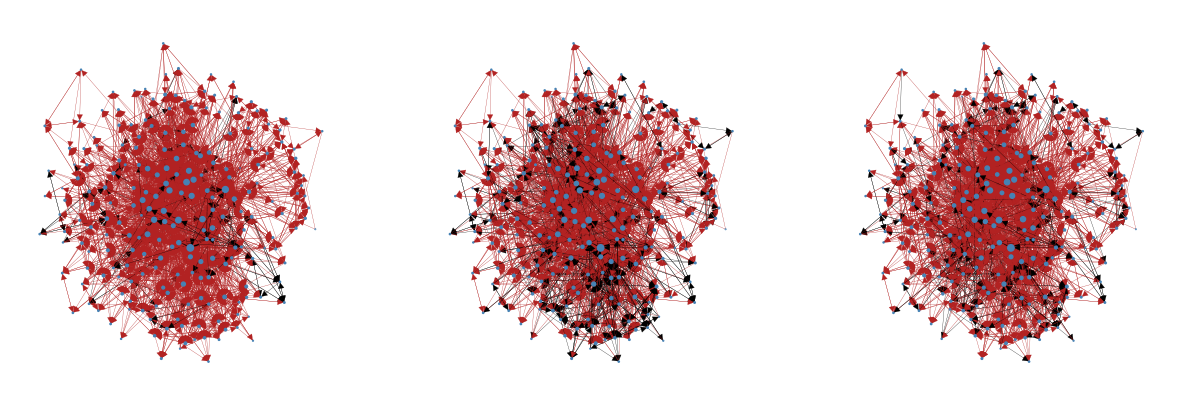

In [96]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

nx.draw_kamada_kawai(di_G, node_size=node_sizes, node_color='steelblue', edge_color=houses_edge_colors, width=0.2, with_labels=False, ax=ax[0])

nx.draw_kamada_kawai(di_G, node_size=node_sizes, node_color='steelblue', edge_color=religion_edge_colors, width=0.2, with_labels=False, ax=ax[1])

nx.draw_kamada_kawai(di_G, node_size=node_sizes, node_color='steelblue', edge_color=culture_edge_colors, width=0.2, with_labels=False, ax=ax[2])

plt.show()

Here we see that in all three cases the magiority of the edges are red. This means that the majority of the links are between characters that do not share house/religion/culture. 

## Network statistics

In the following we calculate some statistics for the graph. The have not been included in the article as they do not really affect the analysis.

### Degree distributions
We plot both the in- and out-degree distributions.

min in-degree: 0
max in-degree: 105
min out-degree: 1
max out-degree: 75


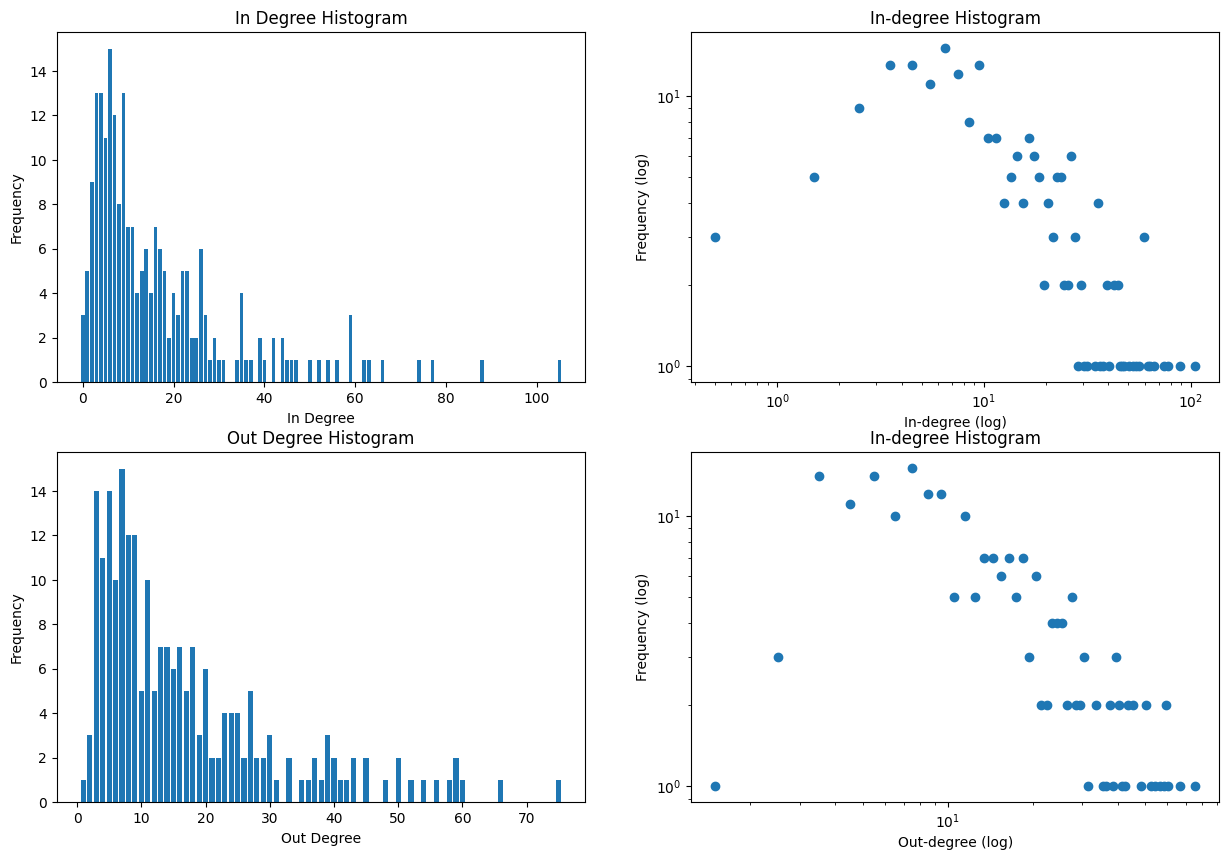

In [97]:
k_in = [di_G.in_degree(node) for node in di_G.nodes()]
k_out = [di_G.out_degree(node) for node in di_G.nodes()]

max_k_in = np.max(k_in)
min_k_in = np.min(k_in)
print(f'min in-degree: {min_k_in}')
print(f'max in-degree: {max_k_in}')
v = np.arange(min_k_in,max_k_in+2)

counts_in, bins_in = np.histogram(k_in, bins=v)
sum_counts_in = np.sum(counts_in)

fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].bar(bins_in[:-1], counts_in)

ax[0,0].set_title("In Degree Histogram")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlabel("In Degree")

ax[0,1].loglog((bins_in[:-1]+bins_in[1:])/2, counts_in, 'o')

ax[0,1].set_title("In-degree Histogram")
ax[0,1].set_ylabel("Frequency (log)")
ax[0,1].set_xlabel("In-degree (log)")

max_k_out = max(k_out)
min_k_out = min(k_out)
print(f'min out-degree: {min_k_out}')
print(f'max out-degree: {max_k_out}')
v = np.arange(min_k_out, max_k_out+2)

counts_out, bins_out = np.histogram(k_out, bins=v)
sum_counts_out = np.sum(counts_out)

ax[1,0].bar(bins_out[:-1], counts_out)
ax[1,0].set_title("Out Degree Histogram")
ax[1,0].set_xlabel("Out Degree")
ax[1,0].set_ylabel("Frequency")

ax[1,1].loglog((bins_out[:-1]+bins_out[1:])/2, counts_out, 'o')

ax[1,1].set_title("In-degree Histogram")
ax[1,1].set_ylabel("Frequency (log)")
ax[1,1].set_xlabel("Out-degree (log)")

plt.show()

We see that the in- and out-degree distributions are very similar. This means that the characters are equally likely to be mentioned on another characters wiki page as they are to mention other characters on they own wiki page.

In [98]:
N = len(di_G.nodes())
avg_k_in = np.mean(k_in)
avg_k_out = np.mean(k_out)
avg_k_in_sq = np.mean(np.square(k_in))
avg_k_out_sq = np.mean(np.square(k_out))
alpha_in = powerlaw.Fit(k_in).alpha
alpha_out = powerlaw.Fit(k_out).alpha


print("<k_in>", avg_k_in)
print("<k_out>", avg_k_out)

print("<k_in^2>", avg_k_in_sq)
print("<k_out^2>", avg_k_out_sq)

print(f'lnN = {np.log(N)}')

print(f'alpha in: {alpha_in}')
print(f'alpha out: {alpha_out}')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
<k_in> 16.828054298642535
<k_out> 16.828054298642535
<k_in^2> 571.7692307692307
<k_out^2> 485.5429864253394
lnN = 5.3981627015177525
alpha in: 2.7021854011900404
alpha out: 3.0860797026662947


Values less than or equal to 0 in data. Throwing out 0 or negative values



The average degree of the network is $\langle k\rangle=16.8$ 
The second mode of the in-degree is $\langle k_{in}^2\rangle=571.8$ and the second mode of the out-degree is $\langle k_{out}^2\rangle=485.5$. These are both much larger than the average degree, indicating degree distributions with heavy tails and outliers, this is also what we in the plots of the degree distributions. The degree exponent for the in- and out-degrees are very different from each other. 

The degree exponent for in-degrees is 2.7, which is between 2 and 3 and it is therefore in the Ultra-Small World regime. Here, there is a balance between local and global connectivity. Most nodes have a small in-degree, but there should be a significant number of nodes with higher in-degrees.

The degree exponent for out-degrees is 3.1 which is not much higher than the degree exponent for in-degrees, however, it is greater than 3 which means it's in the small World regime. In this regime, the majority of nodes have limited outgoing connections, and only a select few nodes have a significantly higher number of outgoing connections. 

### Centrality
We calculate the centrality of the nodes.

In [99]:
print('Sorted in-degrees: ', sorted(di_G.in_degree(), key=lambda x: x[1], reverse=True))
print('Sorted out-degrees: ', sorted(di_G.out_degree(), key=lambda x: x[1], reverse=True))

centrality = nx.degree_centrality(di_G)
betweenness = nx.betweenness_centrality(di_G)
eigenvector = nx.eigenvector_centrality(di_G)

centrality = dict(sorted(centrality.items(), key=lambda x: x[1], reverse=True))
betweenness = dict(sorted(betweenness.items(), key=lambda x: x[1], reverse=True))
print(centrality)
print(betweenness)

r = nx.degree_assortativity_coefficient(di_G)
print(f'degree assortativity coefficient: {r}')

Sorted in-degrees:  [('Jon Snow', 105), ('Daenerys Targaryen', 88), ('Eddard Stark', 77), ('Tyrion Lannister', 74), ('Stannis Baratheon', 66), ('Robb Stark', 63), ('Jaime Lannister', 62), ('Sansa Stark', 59), ('Cersei Lannister', 59), ('Robert Baratheon', 59), ('Varys', 56), ('Arya Stark', 54), ('Roose Bolton', 52), ('Tywin Lannister', 50), ('Joffrey Baratheon', 47), ('Catelyn Stark', 46), ('Gregor Clegane', 45), ('Melisandre', 44), ('Bronn', 44), ('Bran Stark', 42), ('Petyr Baelish', 42), ('Mance Rayder', 40), ('Theon Greyjoy', 39), ('Jorah Mormont', 39), ('Ramsay Bolton', 37), ('Samwell Tarly', 36), ('Brienne of Tarth', 35), ('Barristan Selmy', 35), ('Tormund', 35), ('Night King', 35), ('Pycelle', 34), ('Qyburn', 31), ('Olenna Tyrell', 30), ('Gilly', 29), ('Aerys II Targaryen', 29), ('Rodrik Cassel', 28), ('Renly Baratheon', 27), ('Loras Tyrell', 27), ('Jeor Mormont', 27), ('Podrick Payne', 26), ('Sandor Clegane', 26), ('Mace Tyrell', 26), ('Walder Frey', 26), ('Oberyn Martell', 26),

We see that Jon Snow is both the character with the highest number of in- and out-degrees. This means that he is the character that is mentioned the most on other characters wiki pages and the character that mentions the most other characters on his wiki page. This is not surprising since he is one of the main characters in the series. This naturally leads Jon Snow to also have the highest degree centrality.
In general we see that the characters with the highest number of in- and out-degrees are some of the main characters in the series.
Daenerys Targaryen is the character with the highest betweenness centrality. This means that she is the character that is most likely to be on the shortest path between two other characters. This is also not surprising since she is one of the main characters in the series.

The degree assortativity coefficient tells us is the characters tend to other characters with a similar degree. Since the coefficient is negative but close to zero the network in non-assortative with respect to degree. This means that the characters do not tend to link with other characters with a similar degree but do have a little tendency to link with characters with a different degree.

### Correlation between attributes

Spearman correlation coefficient for out-degree: 0.9039302686134749
Pearson correlation coefficient for out-degree: 0.9171097208111932
Spearman correlation coefficient for in-degree: 0.8456032214872906
Pearson correlation coefficient for in-degree: 0.9171097208111932
Spearman correlation coefficient for number of episodes: 0.8010276802818791
Pearson correlation coefficient for number of episodes: 0.8890937785839061


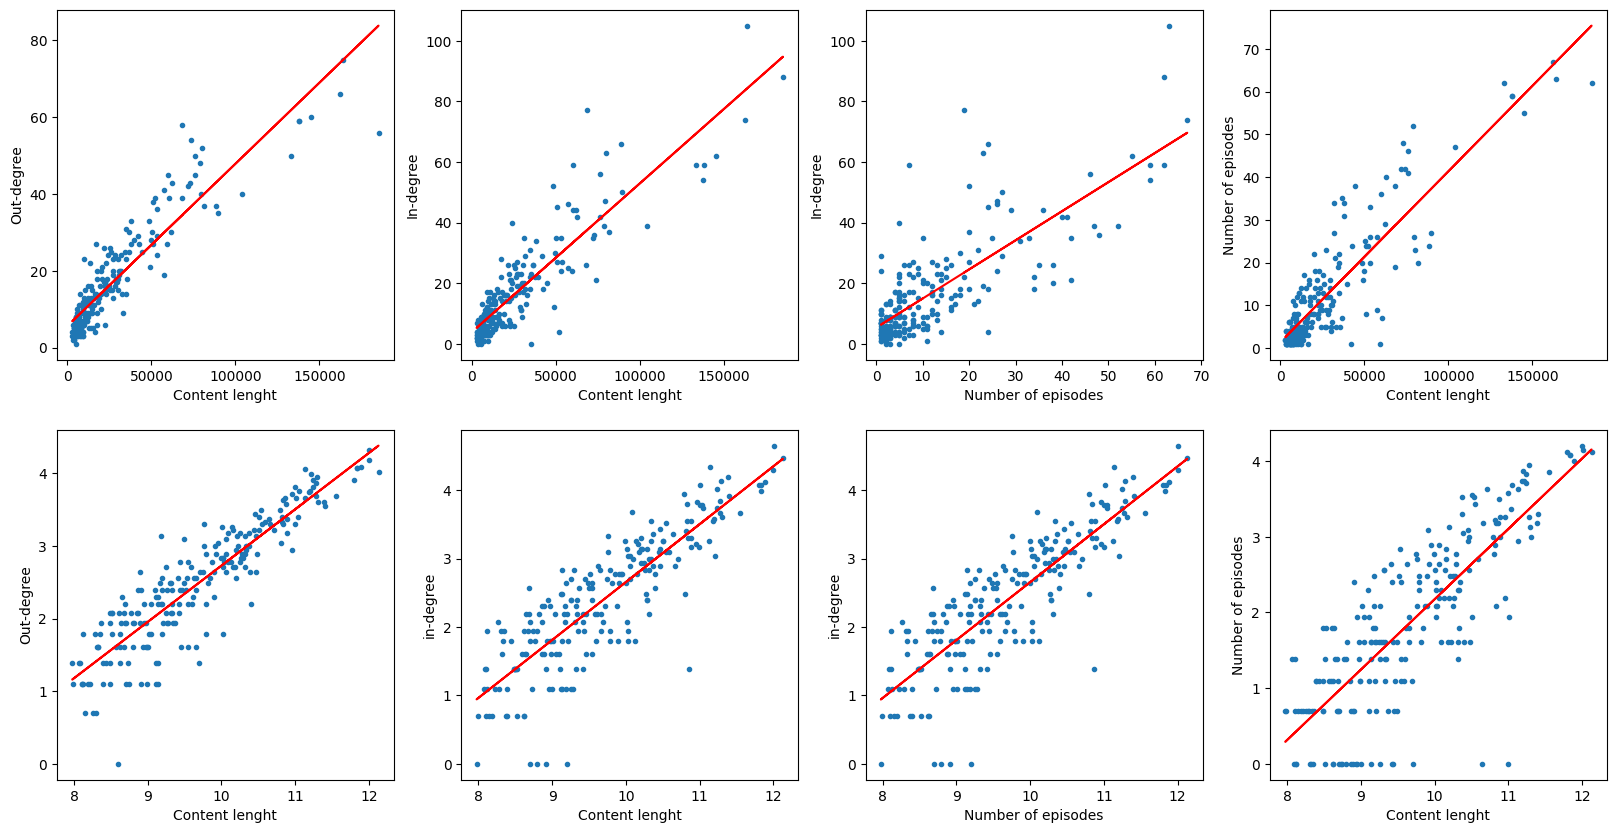

In [100]:
# check correlation between out degree and content length
content_lenght = np.array([d for n, d in di_G.nodes(data='text_len')])
k_out_array = np.array(k_out)
k_in_array = np.array(k_in)
num_episodes = np.array([d for n, d in di_G.nodes(data='num_episodes')])

# calculate spearman correlation coefficient
corr, p = spearmanr(content_lenght, k_out_array)
print(f'Spearman correlation coefficient for out-degree: {corr}')

# calculate pearson correlation coefficient
corr, p = pearsonr(content_lenght, k_out_array)
print(f'Pearson correlation coefficient for out-degree: {corr}')

# calculate spearman correlation coefficient
corr, p = spearmanr(content_lenght, k_in_array)
print(f'Spearman correlation coefficient for in-degree: {corr}')

# calculate pearson correlation coefficient
corr, p = pearsonr(content_lenght, k_out_array)
print(f'Pearson correlation coefficient for in-degree: {corr}')

# calculate spearman correlation coefficient
corr, p = spearmanr(content_lenght, num_episodes)
print(f'Spearman correlation coefficient for number of episodes: {corr}')

# calculate pearson correlation coefficient
corr, p = pearsonr(content_lenght, num_episodes)
print(f'Pearson correlation coefficient for number of episodes: {corr}')

fig, ax = plt.subplots(2, 4, figsize=(20,10))
# fit line to data
slope, intercept, r_value, p_value, std_err = linregress(content_lenght, k_out_array)

ax[0,0].plot(content_lenght, k_out_array, '.')
ax[0,0].plot(content_lenght, intercept + slope*content_lenght, 'r', label='fitted line')
ax[0,0].set_xlabel('Content lenght')
ax[0,0].set_ylabel('Out-degree')

# fit line to data
slope, intercept, r_value, p_value, std_err = linregress(content_lenght, k_in_array)

ax[0,1].plot(content_lenght, k_in_array, '.')
ax[0,1].plot(content_lenght, intercept + slope*content_lenght, 'r', label='fitted line')
ax[0,1].set_xlabel('Content lenght')
ax[0,1].set_ylabel('In-degree')

# fit line to data
slope, intercept, r_value, p_value, std_err = linregress(num_episodes, k_in_array)

ax[0,2].plot(num_episodes, k_in_array, '.')
ax[0,2].plot(num_episodes, intercept + slope*num_episodes, 'r', label='fitted line')
ax[0,2].set_xlabel('Number of episodes')
ax[0,2].set_ylabel('In-degree')


# fit line to data
slope, intercept, r_value, p_value, std_err = linregress(content_lenght, num_episodes)

ax[0,3].plot(content_lenght, num_episodes, '.')
ax[0,3].plot(content_lenght, intercept + slope*content_lenght, 'r', label='fitted line')
ax[0,3].set_xlabel('Content lenght')
ax[0,3].set_ylabel('Number of episodes')


slope, intercept, r_value, p_value, std_err = linregress(np.log(content_lenght), np.log(k_out_array))

ax[1,0].plot(np.log(content_lenght), np.log(k_out_array), '.')
ax[1,0].plot(np.log(content_lenght), intercept + slope*np.log(content_lenght), 'r', label='fitted line')
ax[1,0].set_xlabel('Content lenght')
ax[1,0].set_ylabel('Out-degree')

# remove 0 from k_in_array and the corresponding values from content_length
k_in_array1 = k_in_array[k_in_array != 0]
content_lenght1 = content_lenght[k_in_array != 0]
slope, intercept, r_value, p_value, std_err = linregress(np.log(content_lenght1), np.log(k_in_array1))

ax[1,1].plot(np.log(content_lenght1), np.log(k_in_array1), '.')
ax[1,1].plot(np.log(content_lenght1), intercept + slope*np.log(content_lenght1), 'r', label='fitted line')
ax[1,1].set_xlabel('Content lenght')
ax[1,1].set_ylabel('in-degree')

# remove 0 from k_in_array and the corresponding values from content_length
k_in_array1 = k_in_array[k_in_array != 0]
num_episodes1 = content_lenght[k_in_array != 0]
slope, intercept, r_value, p_value, std_err = linregress(np.log(num_episodes1), np.log(k_in_array1))

ax[1,2].plot(np.log(num_episodes1), np.log(k_in_array1), '.')
ax[1,2].plot(np.log(num_episodes1), intercept + slope*np.log(num_episodes1), 'r', label='fitted line')
ax[1,2].set_xlabel('Number of episodes')
ax[1,2].set_ylabel('in-degree')

slope, intercept, r_value, p_value, std_err = linregress(np.log(content_lenght), np.log(num_episodes))

ax[1,3].plot(np.log(content_lenght), np.log(num_episodes), '.')
ax[1,3].plot(np.log(content_lenght), intercept + slope*np.log(content_lenght), 'r', label='fitted line')
ax[1,3].set_xlabel('Content lenght')
ax[1,3].set_ylabel('Number of episodes')
plt.show()

We see that the out-degrees are positively correlated with the content lenght, which is to be expected since the longer the text the more likely it is to mention other characters. This does however not explain why the in-degrees are also positively correlated with the content length. However we see that the in-degree is also postively correlated with the number episodes the character appears in. This makes sence since the more episodes a character appears in the more likely it is to be mentioned on other characters wiki pages and the more episodes a character appears in the more there is to write about the character, thus explaining why the in-degree is also positively correlated with the content length.

## Communities
We anaylse 4 different sets of communities in the netwrok
1. The communities obtained by splitting the characters into their houses
2. The communities obtained by splitting the characters into their religions
3. The communities obtained by splitting the characters into their cultures
4. The communities obtained by the Louvain algorithm

We start by calculating some statisics for the communities.

Assortativity measures how much nodes prefer to link with nodes with a specific attribute. The assortativity coefficient ranges between -1 and 1. 1 means that nodes that share a specific property always connect to each other whereas -1 means they never connect. 0 is the neutral case. Assortativity is calculated as:
\begin{equation*}
    r = \sum_{jk} \frac{jk(e_{jk}-q_jq_k)}{\sigma^2}
\end{equation*}

where $e_{jk}$ is the probability of finding a node with attribute values $j$ and $k$ at the two ends of a randomly selected link. $q_j$ is the probability of finding a node with attribute value $j$ and $\sigma^2$ is the variance of the attribute distribution. 

Modularity measures the quality of a split in a network into communities. It quantifies the degree to which the number of edges within communities is greater than the expected number in an equivalent random network. This measure helps in identifying the community structure of the network and can be useful in understanding the organization and function of complex systems. Modularity for a partition is calculated as:

\begin{equation*}
    M = \sum_{c=1}^{n_c} \left(\frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^2\right)
\end{equation*}

where $n_c$ is the number of communities, $k_c$ is the total degree of the nodes in the community, $L$ is the total number of links in the network and $L_c$ is the total number of links within a community.

In [101]:
house_sizes = {}
houses_text_len = {}
houses_avg_text_len = {}
for house in houses_list:
    house_sizes[house] = 0
    houses_text_len[house] = 0

for node, data in di_G.nodes(data=True):
    houses = data['houses'].split(', ')
    for house in houses:
        house_sizes[house] += 1
        houses_text_len[house] += data['text_len']
        
for house in houses_list:
    houses_avg_text_len[house] = houses_text_len[house]/house_sizes[house]

# sorting
house_sizes = dict(sorted(house_sizes.items(), key=lambda x: x[1], reverse=True))
houses_text_len = dict(sorted(houses_text_len.items(), key=lambda x: x[1], reverse=True))
houses_avg_text_len = dict(sorted(houses_avg_text_len.items(), key=lambda x: x[1], reverse=True))
print(f'Number of houses: {len(houses_list)}')
print(f'house sizes: {house_sizes}')
print(f'houses average text lenghts: {houses_avg_text_len}')

Number of houses: 56
house sizes: {'No house': 107, 'House Stark': 11, 'House Baratheon': 11, 'House Lannister': 9, 'House Targaryen': 7, 'House Frey': 6, 'House Tully': 5, 'House Greyjoy': 5, 'House Tarly': 5, 'House Bolton': 4, 'House Tyrell': 4, 'House Umber': 3, 'House Karstark': 3, 'House Mormont': 3, 'House Reed': 3, 'House Martell': 3, 'House Cassel': 2, 'House Payne': 2, 'House Clegane': 2, 'House Florent': 2, 'House Seaworth': 2, 'House Arryn': 2, 'House Baelish': 2, 'House Waynwood': 2, 'House Glover': 1, 'House Cerwyn': 1, 'House Manderly': 1, 'House Lorch': 1, 'House Tarth': 1, 'House Egen': 1, 'House Royce': 1, 'House Corbray': 1, 'House Redwyne': 1, 'House Kenning': 1, 'House Erenford': 1, "Bronn's house": 1, 'Maegyr family': 1, 'House Selmy': 1, 'House Trant': 1, 'House Dondarrion': 1, 'House Slynt': 1, 'House Stokeworth': 1, 'House Hollard': 1, 'House Thorne': 1, 'House Marsh': 1, 'House Yarwyck': 1, 'House Tollett': 1, 'House Mallister': 1, 'House Strickland': 1, 'Hous

We see that we have a total of 56 houses, including 'No house'. We have a lot of characters that do not belong to a house. We also se that we have a lot of houses of size 1. Excluding 'No house', the largest house is House Stark. We also see that there is a great difference in the average text length of the houses, House Lannister with an average text lenght of 90864 and House Corbray with an average text lenght of 3255.

In [102]:
culture_sizes = {}
cultures_text_len = {}
cultures_avg_text_len = {}
for culture in cultures_list:
    culture_sizes[culture] = 0
    cultures_text_len[culture] = 0

for node, data in di_G.nodes(data=True):
    culture = data['culture']
    culture_sizes[culture] += 1
    cultures_text_len[culture] += data['text_len']

for culture in cultures_list:
    cultures_avg_text_len[culture] = cultures_text_len[culture]/culture_sizes[culture]

# sorting
culture_sizes = dict(sorted(culture_sizes.items(), key=lambda x: x[1], reverse=True))
cultures_text_len = dict(sorted(cultures_text_len.items(), key=lambda x: x[1], reverse=True))
cultures_avg_text_len = dict(sorted(cultures_avg_text_len.items(), key=lambda x: x[1], reverse=True))
print(f'Number of cultures: {len(cultures_list)}')
print(f'culture sizes: {culture_sizes}')
print(f'cultures average text length: {cultures_avg_text_len}')

Number of cultures: 37
culture sizes: {'Andals': 47, 'Northmen': 32, 'No culture': 31, 'Free Folk': 10, 'Dothraki': 9, 'Ironborn': 8, 'Crownlands': 7, 'Dornishmen': 7, 'Ghiscari': 7, 'Westerlands': 6, 'Riverlands': 5, 'Valyrians': 5, 'Crannogmen': 4, 'Stormlands': 4, 'Reach': 4, 'Dornish Marches': 3, 'Volantis': 3, 'Braavos': 3, 'Asshai': 2, 'Summer Islands': 2, 'Vale of Arryn': 2, 'Lorath': 2, 'Lys': 2, 'Thenns': 2, 'Giants': 2, 'Yi Ti': 1, 'Norvos': 1, 'Westeros': 1, 'Hill tribes': 1, 'Myr': 1, 'Children of the Forest': 1, 'First Men': 1, 'Lhazar': 1, 'Pentos': 1, 'Lhazareen': 1, 'Naath': 1, 'Tyrosh': 1}
cultures average text length: {'Westerlands': 108229.66666666667, 'Valyrians': 70686.8, 'Stormlands': 67954.0, 'Westeros': 60024.0, 'Vale of Arryn': 50559.0, 'Crownlands': 45867.28571428572, 'Naath': 44648.0, 'Lys': 44304.5, 'Reach': 43614.5, 'Dornish Marches': 42688.333333333336, 'Northmen': 38685.9375, 'Asshai': 34549.5, 'Ironborn': 34492.25, 'Riverlands': 32817.2, 'Tyrosh': 32597.

We see that we have a total of 37 cultures, including 'No culture'. Again we see that we have a lot of cultures of size 1. The largest cultures are the Andals and the Northmen. Again we see that there is a great difference in the average text length of the cultures, Westerlands with an average text lenght of 108212 and Lhazar with an average text lenght of 3971.

In [103]:
# Get religion sizes
religion_sizes = {}
religions_text_len = {}
religion_avg_text_len = {}
for religion in religions_list:
    religion_sizes[religion] = 0
    religions_text_len[religion] = 0

for node, data in di_G.nodes(data=True):
    religion = data['religion']
    religion_sizes[religion] += 1
    religions_text_len[religion] += data['text_len']

for religion in religions_text_len:
    religion_avg_text_len[religion] = religions_text_len[religion]/religion_sizes[religion]

# sorting
religion_sizes = dict(sorted(religion_sizes.items(), key=lambda x: x[1], reverse=True))
religions_text_len = dict(sorted(religions_text_len.items(), key=lambda x: x[1], reverse=True))
religion_avg_text_len = dict(sorted(religion_avg_text_len.items(), key=lambda x: x[1], reverse=True))
print(f'Number of religions: {len(religions_list)}')
print(f'regligion sizes: {religion_sizes}')
print(f'religions average text lengths: {religion_avg_text_len}')

Number of religions: 10
regligion sizes: {'No religion': 83, 'Faith of the Seven': 61, 'Old Gods of the Forest': 40, "R'hllor": 9, 'Great Stallion': 9, 'Drowned God': 7, 'Ghiscari religion': 6, 'Many-Faced God': 3, 'Great Shepherd': 2, 'White Walkers': 1}
religions average text lengths: {'Faith of the Seven': 31227.868852459018, 'Drowned God': 31217.428571428572, 'No religion': 27008.33734939759, 'Old Gods of the Forest': 25994.075, "R'hllor": 25639.555555555555, 'White Walkers': 18315.0, 'Many-Faced God': 16732.0, 'Ghiscari religion': 9665.333333333334, 'Great Stallion': 8863.333333333334, 'Great Shepherd': 5509.0}


We see that we have a total of 10 religions, including 'No religion'. We again see that a lot of characters to not have a religion, however since there are so few religions compared to houses and cultures we also see that there is only one religion of size 1. Excluding 'No religion', the largest religions are the Faith of the Seven and the Old Gods of the Forest. Again since do to the low number of religions we do not see as great a difference in the average text length of the religions, Faith of the Seven with an average text lenght of 31225 and Great Shepherd with an average text lenght of 5509.


Now we use the Louvain algorithm to find the best partitioning of the graph into communities.

In [104]:
best_partition = community.best_partition(G, random_state = 42)
best_partition_sizes = {}
best_partition_text_len = {}
best_partition_avg_text_len = {}
for best_part in set(best_partition.values()):
    best_partition_sizes[best_part] = 0
    best_partition_text_len[best_part] = 0

for node, data in di_G.nodes(data=True):
    best_part = best_partition[node]
    best_partition_sizes[best_part] += 1
    best_partition_text_len[best_part] += data['text_len']
    di_G.nodes[node]['best_partition'] = best_part

for best_part in set(best_partition.values()):
    best_partition_avg_text_len[best_part] = best_partition_text_len[best_part]/best_partition_sizes[best_part]

# sorting
best_partition_sizes = dict(sorted(best_partition_sizes.items(), key=lambda x: x[1], reverse=True))
best_partition_text_len = dict(sorted(best_partition_text_len.items(), key=lambda x: x[1], reverse=True))
best_partition_avg_text_len = dict(sorted(best_partition_avg_text_len.items(), key=lambda x: x[1], reverse=True))

print(f'Number of best partition communities: {len(set(best_partition.values()))}')
print(f'best partition community sizes: {best_partition_sizes}')
print(f'best partition average text lengths: {best_partition_avg_text_len}')

Number of best partition communities: 6
best partition community sizes: {4: 56, 1: 52, 5: 45, 2: 35, 3: 24, 0: 9}
best partition average text lengths: {1: 36320.63461538462, 0: 31341.555555555555, 5: 25160.71111111111, 4: 24276.89285714286, 3: 20306.041666666668, 2: 20088.4}


We see that the Louvain algorithm finds 6 communities. We see that the largest community is community 4 with 55 of the nodes and the smallest community is community 0 with 9 of the nodes. We also see that the average text length of the communities is very similar.

Since the characters that do not belong to a house/religion/culture do not contribute to the analyis of the sentiments of the communities generated by the houses/religions/cultures, the will be excluded from parts of the followin analysis. The same goes for the character belonging to a house/religion/culture consisting only of the character, as one character cannot give enough statitical information about a house/religion/culture. We generate graphs where we leave out the all characters that do not belong to a houses/religion/culture or belong to a house/religion/culture consisting only of the character.

In [105]:
# lists of all houses/religions/cultures with more than 1 character 
houses_list_1 = [house for house in houses_list if house_sizes[house] > 1 and house != 'No house']

religions_list_1 = [religion for religion in religions_list if religion_sizes[religion] > 1 and religion != 'No religion']

cultures_list_1 = [culture for culture in cultures_list if culture_sizes[culture] > 1 and culture != 'No culture']


di_G_with_houses = nx.DiGraph()
di_G_with_religions = nx.DiGraph()
di_G_with_cultures = nx.DiGraph()

houses_nodes = []
religions_nodes = []
cultures_nodes = []

for node, data in di_G.nodes(data=True):
    
    houses = data['houses']
    houses = houses.split(', ')
    new_houses = []
    for house in houses:
        if house in houses_list_1:
            new_houses.append(house)
    houses = new_houses
    houses_string = ', '.join(houses)
    culture = data['culture']
    religion = data['religion']
    new_data = data.copy()
    
    if houses_string != '':
        new_data['houses'] = houses_string
        new_data['first_house'] = houses[0]
        di_G_with_houses.add_node(node, **new_data)
    
    if religion in religions_list_1:
        di_G_with_religions.add_node(node, **new_data)

    if culture in cultures_list_1:
        di_G_with_cultures.add_node(node, **new_data)

for node, data in di_G.nodes(data=True):
    if node in di_G_with_houses.nodes():

        out_edges = di_G.out_edges(node)
        for edge in out_edges:
            if edge[1] in di_G_with_houses.nodes():
                di_G_with_houses.add_edge(edge[0], edge[1])
    if node in di_G_with_religions.nodes():

        out_edges = di_G.out_edges(node)
        for edge in out_edges:
            if edge[1] in di_G_with_religions.nodes():
                di_G_with_religions.add_edge(edge[0], edge[1])
    if node in di_G_with_cultures.nodes():

        out_edges = di_G.out_edges(node)
        for edge in out_edges:
            if edge[1] in di_G_with_cultures.nodes():
                di_G_with_cultures.add_edge(edge[0], edge[1])

# Add main house attribute
for node in di_G_with_houses.nodes():
    di_G_with_houses.nodes[node]['main_house'] = main_house(node, di_G_with_houses, houses_list_1)

G_with_houses = di_G_with_houses.to_undirected()
G_with_religions = di_G_with_religions.to_undirected()
G_with_cultures = di_G_with_cultures.to_undirected()

We visualize the new graphs, as we did with the original graph.

In [106]:
node_sizes_houses = [(di_G_with_houses.in_degree(node)+1)/5 for node in di_G_with_houses]

houses_edge_colors = []
for edge in di_G_with_houses.edges():
    node_0 = di_G_with_houses.nodes[edge[0]]
    node_1 = di_G_with_houses.nodes[edge[1]]
    houses_0 = node_0['houses'].split(', ')
    houses_1 = node_1['houses'].split(', ')

    common_house = False
    for house_0 in houses_0:
        if house_0 in houses_1 and house_0 != 'No house':
            common_house = True
            break
    
    if common_house:
        houses_edge_colors.append('black')
    else:
        houses_edge_colors.append('firebrick')

node_sizes_religions = [(di_G_with_religions.in_degree(node)+1)/5 for node in di_G_with_religions]

religion_edge_colors = []
for edge in di_G_with_religions.edges():
    node_0 = di_G_with_religions.nodes[edge[0]]
    node_1 = di_G_with_religions.nodes[edge[1]]
    religion_0 = node_0['religion']
    religion_1 = node_1['religion']
    common_religion = False
    if religion_0 == religion_1 and religion_0 != 'No religion':
        common_religion = True
    
    if common_religion:
        religion_edge_colors.append('black')
    else:
        religion_edge_colors.append('firebrick')

node_sizes_cultures = [(di_G_with_cultures.in_degree(node)+1)/5 for node in di_G_with_cultures]

culture_edge_colors = []
for edge in di_G_with_cultures.edges():
    node_0 = di_G_with_cultures.nodes[edge[0]]
    node_1 = di_G_with_cultures.nodes[edge[1]]
    culture_0 = node_0['culture']
    culture_1 = node_1['culture']
    common_culture = False
    if culture_0 == culture_1 and culture_0 != 'No culture':
        common_culture = True
    
    if common_culture:
        culture_edge_colors.append('black')
    else:
        culture_edge_colors.append('firebrick')


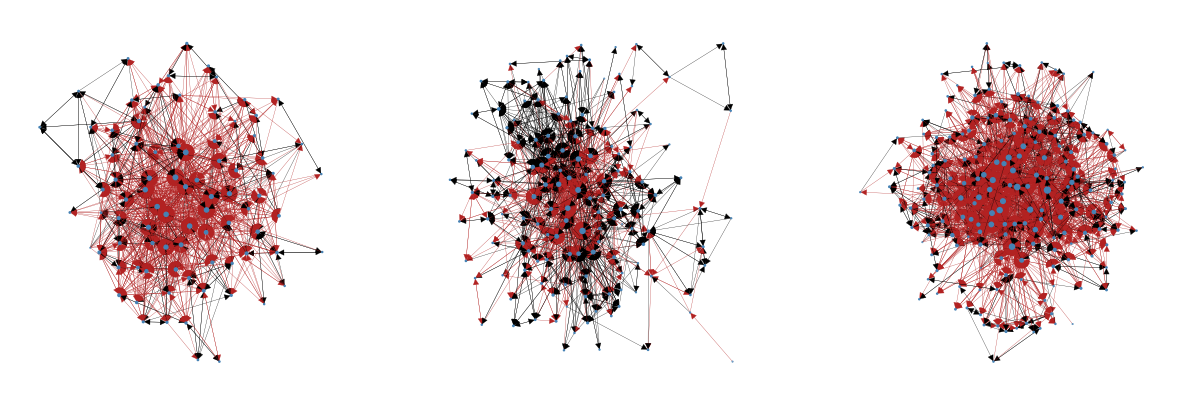

In [107]:

fig, ax = plt.subplots(1,3, figsize=(15,5))

nx.draw_kamada_kawai(di_G_with_houses, node_size=node_sizes_houses, node_color='steelblue', edge_color=houses_edge_colors, width=0.2, with_labels=False, ax=ax[0])

nx.draw_kamada_kawai(di_G_with_religions, node_size=node_sizes_religions, node_color='steelblue', edge_color=religion_edge_colors, width=0.2, with_labels=False, ax=ax[1])

nx.draw_kamada_kawai(di_G_with_cultures, node_size=node_sizes_cultures, node_color='steelblue', edge_color=culture_edge_colors, width=0.2, with_labels=False, ax=ax[2])

plt.show()


We see that the proportion of black edges is much larger in the new graphs, especially when looking at the religions, indicating that there could be some communities in the network based on the characters religion.

To analyse which communities are most connected to each other, we generate undirected graphs over the houses, religions and cultures, where the weights of the edges are the number of edges between characters that belong to the specific houses/religions/cultures weighted by the number of possible links between the specific houses/religions/cultures.

In [108]:
G_houses = nx.Graph()
for house in houses_list_1:
    G_houses.add_node(house, size=house_sizes[house], text_len=houses_avg_text_len[house], sentiment=0)

for house1 in houses_list_1:
    houses_list_2 = houses_list_1.copy()
    houses_list_2.remove(house1)
    houses_2 = freq_connected_attribute_to(house1, di_G_with_houses, 'houses', houses_list_2)
    for house2 in houses_2:
        if house2 != house1 and houses_2[house2] != 0:
            G_houses.add_edge(house1, house2, weight=(houses_2[house2])/(house_sizes[house1]*house_sizes[house2]))

G_religions = nx.Graph()
for religion in religions_list_1:
    G_religions.add_node(religion, size=religion_sizes[religion], text_len=religion_avg_text_len[religion], sentiment=0)

for religion1 in religions_list_1:
    religions_list_2 = religions_list_1.copy()
    religions_list_2.remove(religion1)
    religions_2 = freq_connected_attribute_to(religion1, di_G_with_religions, 'religion', religions_list_2)
    for religion2 in religions_2:
        if religion2 != religion1 and religions_2[religion2] != 0:
            G_religions.add_edge(religion1, religion2, weight=(religions_2[religion2])/(religion_sizes[religion1]*religion_sizes[religion2]))


G_cultures = nx.Graph()
for culture in cultures_list_1:
    G_cultures.add_node(culture, size=culture_sizes[culture], text_len=cultures_avg_text_len[culture], sentiment=0)
    
for culture1 in cultures_list_1:
    cultures_list_2 = cultures_list_1.copy()
    cultures_list_2.remove(culture1)
    cultures_2 = freq_connected_attribute_to(culture1, di_G_with_cultures, 'culture', cultures_list_2)
    for culture2 in cultures_2:
        if culture2 != culture1 and cultures_2[culture2] != 0:
            G_cultures.add_edge(culture1, culture2, weight=(cultures_2[culture2])/(culture_sizes[culture1]*culture_sizes[culture2]))



In [109]:
# nodes sizes are the size of the house/religion/culture
# edge sizes are the weights
# node colors are in the range from green to red based on the sentiment


node_sizes_houses = [house_sizes[house]*20 for house in G_houses.nodes()]

edge_sizes_houses = [(G_houses.edges[edge]['weight']*7) for edge in G_houses.edges()]


node_sizes_religions = [religion_sizes[religion]*20 for religion in G_religions.nodes()]


edge_sizes_religions = [(G_religions.edges[edge]['weight']*30) for edge in G_religions.edges()]

node_sizes_cultures = [culture_sizes[culture]*20 for culture in G_cultures.nodes()]


edge_sizes_cultures = [(G_cultures.edges[edge]['weight']*7) for edge in G_cultures.edges()]

edge_colors_houses = ['gray' for edge in G_houses.edges()]
edge_colors_religions = ['gray' for edge in G_religions.edges()]
edge_colors_cultures = ['gray' for edge in G_cultures.edges()]


pos_houses = nx.circular_layout(G_houses)
pos_religions = nx.circular_layout(G_religions)
pos_cultures = nx.circular_layout(G_cultures)


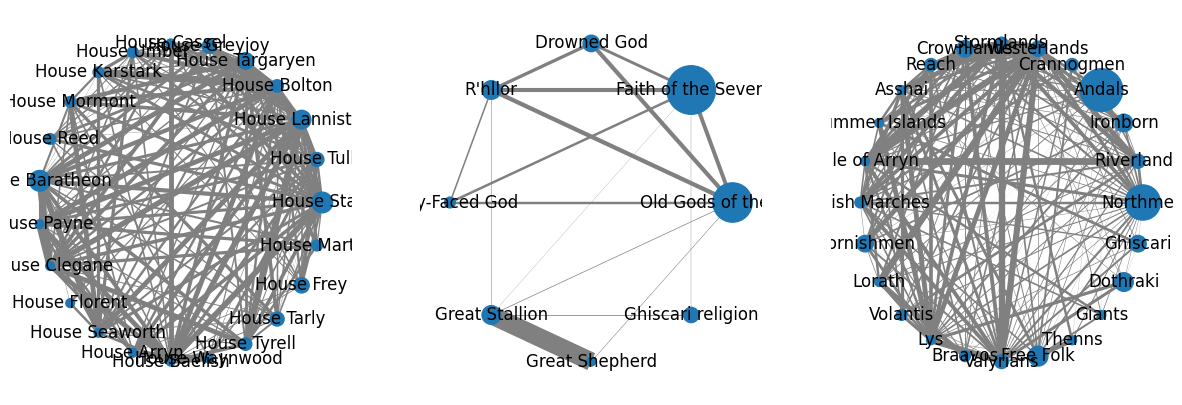

In [110]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
nx.draw(G_houses, pos_houses, node_size=node_sizes_houses,width=edge_sizes_houses, with_labels=True, edge_color=edge_colors_houses, ax=ax[0])

nx.draw(G_religions, pos_religions, node_size=node_sizes_religions, width=edge_sizes_religions, with_labels=True, edge_color=edge_colors_religions, ax=ax[1])

nx.draw(G_cultures, pos_cultures, node_size=node_sizes_cultures, width=edge_sizes_cultures, with_labels=True, edge_color=edge_colors_cultures, ax=ax[2])
plt.show()


The three graphs show the graphs over the houses, religions and cultures. The sizes of the nodes are the sizes of the houses/religions/cultures and the sizes of the edges are the weight e.i. the number of connectections between characters with the specific houses/religions/cultures in the original graph.

### Assortativity coefficients

In [111]:
print('\nExcluding characters without houses/religions/cultures:')
r = nx.attribute_assortativity_coefficient(di_G_with_houses, 'main_house')
print(f'main house assortativity coefficient: {r}')


r = nx.attribute_assortativity_coefficient(di_G_with_religions, 'religion')
print(f'religion assortativity coefficient: {r}')


r = nx.attribute_assortativity_coefficient(di_G_with_cultures, 'culture')
print(f'culture assortativity coefficient: {r}')


r = nx.attribute_assortativity_coefficient(di_G, 'best_partition')
print(f'best partition assortativity coefficient: {r}')




Excluding characters without houses/religions/cultures:
main house assortativity coefficient: 0.08454036666802839
religion assortativity coefficient: 0.3247273813271343
culture assortativity coefficient: 0.0981927143222505
best partition assortativity coefficient: 0.4507278008434942


We see that all the assortativity coefficients are positive, which means that the network is assortative with respect to all the attributes. This means that the characters tend to link with other characters with the same attribute. However for both main house and culture the assortativity coefficients are very close to zero, which means that the network is only slightly assortative with respect to these attributes. 


### Modularity

We now calculate the modularity for each of the community splits also for the split obtained by the Louvain algorithm on the graph where we exclude all the nodes that do not have a house/reigion/culture for better comparison.

In [113]:
best_M = community.modularity(best_partition, G)
print(f'Modularity for the best partiontion communities: {best_M}')
print(f'Number of best partition communities: {len(set(best_partition.values()))}')
print(f'Number of nodes in best partition communities: {len(G)}')

Modularity for the best partiontion communities: 0.3358652574965447
Number of best partition communities: 6
Number of nodes in best partition communities: 221


In [114]:
dict_houses = {}
for i, house in enumerate(houses_list_1):
    dict_houses[house] = i

main_house_partition = {}

for node in G_with_houses.nodes():
    main_house = G_with_houses.nodes[node]['main_house']
    main_house_partition[node] = dict_houses[main_house]
    
main_house_M = community.modularity(main_house_partition, G_with_houses)
print(f'Modularity for the house communities: {main_house_M}')
print(f'Number of house communities: {len(houses_list_1)}')
print(f'Number of nodes in house communities: {len(G_with_houses)}')

Modularity for the house communities: 0.0531076388888889
Number of house communities: 23
Number of nodes in house communities: 85


In [115]:
dict_cultures = {}
for i, culture in enumerate(cultures_list_1):
    dict_cultures[culture] = i


culture_partition = {}
for node in G_with_cultures.nodes():
    culture = G_with_cultures.nodes[node]['culture']
    culture_partition[node] = dict_cultures[culture]
    
culture_M = community.modularity(culture_partition, G_with_cultures)
print(f'Modularity for the culture communities: {culture_M}')
print(f'Number of culture communities: {len(cultures_list_1)}')
print(f'Number of nodes in culture communities: {len(G_with_cultures)}')

Modularity for the culture communities: 0.07285949728783786
Number of culture communities: 24
Number of nodes in culture communities: 178


In [116]:
dict_religions = {}
for i, religion in enumerate(religions_list_1):
    dict_religions[religion] = i


religion_partition = {}

for node in G_with_religions.nodes():
    religion = G_with_religions.nodes[node]['religion']
    religion_partition[node] = dict_religions[religion]
    
religion_M = community.modularity(religion_partition, G_with_religions)
print(f'Modularity for the religion communities: {religion_M}')
print(f'Number of religion communities: {len(religions_list_1)}')
print(f'Number of nodes in religion communities: {len(G_with_religions)}')

Modularity for the religion communities: 0.19260679999443903
Number of religion communities: 8
Number of nodes in religion communities: 137


The modularity of the communities obtained by the Louvain algorithm is naturally higher than the modularity obtained by communities constructed by the houses, cultures, or religions since the aim of the Louvain algorithm is to obtain the community split with the highest modularity. 
The modularity for partitioning obtained by the Louvain algorithm is 0.34. If we use the Louvain algorithm on the graph where we exclude all the nodes that do not have a house/religion/culture, the modularity decreases in all cases. 

Besides the community split obtained by the Louvain algorithm, we found the community split obtained by the religions led to the highest modularity, followed by the community split obtained by the cultures, and lastly, the community split obtained by the houses had the lowest modularity. 

Thus is most likely do the number of nodes per community for the houses is the furtherst away from the nodes per community for the split obtained by the Louvain algorithm, whereas the number of nodes per community for the religions is the most similar to the split obtained by the Louvain algorithm


## Sentiment analysis

We already calculated the average sentiment score for each of the characters and included it as an attribute in the graph.
We now analyse the sentiments of the characters and the communities. We start by analysing the sentiments of the characters by calculating the assorativity coefficients with respect to the sentiments. 

In [117]:
r = nx.attribute_assortativity_coefficient(di_G, 'sentiment')
print(f'sentiment assortativity coefficient: {r}')

sentiment assortativity coefficient: -0.008075486561239357


The assortativity coefficient is negative but very close to zero, thus the network is non-assortative with respect to sentiment with a slight tendency to link with characters with a different sentiment.

We now look at the distribution of the sentiments of the characters.

In [118]:
characters_sentiments = {}
for name in names:
    characters_sentiments[name] = characters[name]['sentiment']

sentiments=dict(sorted(characters_sentiments.items(), key=lambda x:x[1], reverse=True))
lowest_character = list(sentiments.keys())[-1]
highest_character = list(sentiments.keys())[0]
print(f'Charachers sentiments: {sentiments}')
mean_sentiment = np.mean(list(sentiments.values()))
print(f'mean sentiment: {mean_sentiment}')

Charachers sentiments: {'Talla Tarly': 5.529004854368929, 'Walda Bolton': 5.521348511383533, 'Melessa Tarly': 5.510585858585858, 'Roslin Tully': 5.505944309927355, 'Bernadette': 5.495778688524588, 'Ternesio Terys': 5.481174698795179, 'Moro': 5.467292724196272, 'Kitty Frey': 5.4630616740088085, 'Joyeuse Frey': 5.462453987730059, 'Anya Waynwood': 5.458746666666665, 'Lollys Stokeworth': 5.457144970414198, 'Leaf': 5.449579684763569, 'Donnel Waynwood': 5.433333333333334, 'High Septon (Joffrey)': 5.428569051580697, 'Steelshanks': 5.4272631578947355, 'Prendahl na Ghezn': 5.426723549488054, 'Matthos Seaworth': 5.425050125313277, 'Selyse Baratheon': 5.424962025316458, 'Zanrush': 5.420472440944881, 'Lyanna Stark': 5.41957794034891, 'Ros': 5.413762096774191, 'Marei': 5.40864636209813, 'Caleotte': 5.4075496688741715, 'Vance Corbray': 5.405808580858083, 'Lothar Frey': 5.404445488721796, 'Tycho Nestoris': 5.400397140587768, 'Dim Dalba': 5.39978873239437, 'Shireen Baratheon': 5.397005907626205, 'Wald

We see that the characher with the highest  sentiment score is Talla Tarly with a sentiment score of 5.53 and the character with the lowest sentiment score is Polliver with a sentiment score of 5.17. 

5.169454094292797
5.529004854368929


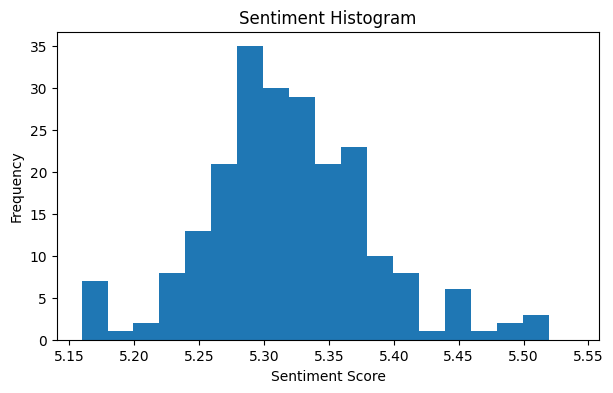

In [119]:
sentiments_list = list(sentiments.values())
max_s = max(sentiments_list)
min_s = min(sentiments_list)
print(min_s)
print(max_s)


v = np.arange(min_s, max_s + 0.04, 0.02)

s_counts, s_bins = np.histogram(sentiments_list, bins=v)

plt.figure(figsize=(7,4))
plt.bar(s_bins[:-1], s_counts, width=np.diff(s_bins))
plt.title("Sentiment Histogram")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

We see that the sentiment score distribution seems normally distributed.

We now look at the sentiment scores of the communities. We calculate the average sentiment score for each of the communities as well as the standard deviation and visualize the results as boxplots.

We see that we have a lot of houses with a standard deviation of 0. This means that all the characters in the house have the same sentiment score. This is most likely because there is only one character belonging to the house. We also see that the charachers that to not belong to a house have sthe largest standard deviation. This does indicate that the charachers do share some similarities in their sentiments with the other characters in their house.

To get a better understanding of the sentiment scores of the communities we only include the houses/reigions/cultures with more than 1 character and that do belong to a house/reigion/culture.

In [120]:
houses_sentiments = {}
houses_avg_sentiment = {}
houses_std_sentiment = {}

# initialize house sentiments and size to 0
for house in houses_list_1:
    # only including houses with more than 1 member
    houses_sentiments[house] = []

# Calculate the total sentiment
for node, attributes in di_G_with_houses.nodes(data=True):
    all_houses = attributes['houses'].split(', ')

    sentiment = sentiments[node]
    
    for house in all_houses:
        houses_sentiments[house].append(sentiment)


# Calculate the average sentiment

for house in houses_list_1:
    houses_avg_sentiment[house] = np.mean(houses_sentiments[house])
    houses_std_sentiment[house] = np.std(houses_sentiments[house])
    G_houses.nodes[house]['sentiment'] = houses_avg_sentiment[house]

mean_std_houses = np.mean(list(houses_std_sentiment.values()))
std_avg_houses = np.std(list(houses_avg_sentiment.values()))

houses_avg_sentiment = dict(sorted(houses_avg_sentiment.items(), key=lambda x: x[1], reverse=True))
houses_std_sentiment = dict(sorted(houses_std_sentiment.items(), key=lambda x: x[1], reverse=True))

print(f'houses average sentiment: {houses_avg_sentiment}')
print(f'houses std sentiment: {houses_std_sentiment}')


houses average sentiment: {'House Florent': 5.467773941951158, 'House Frey': 5.458926743460572, 'House Waynwood': 5.446039999999999, 'House Tarly': 5.397280115908376, 'House Tully': 5.375795399527197, 'House Bolton': 5.373552438258869, 'House Arryn': 5.3694328498013295, 'House Tyrell': 5.367440321594062, 'House Seaworth': 5.363488812519751, 'House Reed': 5.346699111566527, 'House Baratheon': 5.346479706698525, 'House Baelish': 5.344728969405199, 'House Stark': 5.343561526865297, 'House Mormont': 5.339150109415421, 'House Targaryen': 5.332873105664634, 'House Umber': 5.324197594903414, 'House Greyjoy': 5.317275311710873, 'House Lannister': 5.316434487344661, 'House Martell': 5.315440512218991, 'House Payne': 5.313155722386832, 'House Karstark': 5.281537745042035, 'House Cassel': 5.262677652312728, 'House Clegane': 5.234221447002979}
houses std sentiment: {'House Tarly': 0.10128222215525161, 'House Bolton': 0.08976051249851667, 'House Tully': 0.06577098715982194, 'House Seaworth': 0.0615

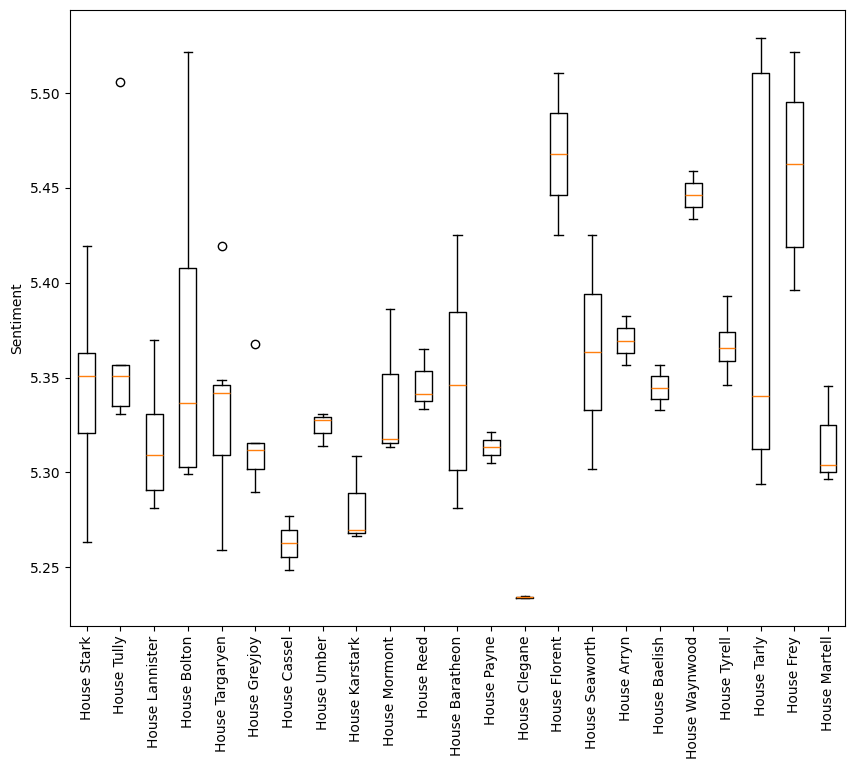

In [121]:
plt.figure(figsize=(10, 8))
plt.boxplot([houses_sentiments[house] for house in houses_list_1])
plt.xticks(np.arange(1, len(houses_list_1)+1), houses_list_1, rotation=90)
plt.ylabel('Sentiment')
plt.show()

We see that the house with the highest average sentiment score is House Florent with an average sentiment score of 5.47 and the house with the lowest average sentiment score is House Clegane with an average sentiment score of 5.23. We also see that the house with the highest standard deviation is House Tarly with a standard deviation of 0.101 and the house with the lowest standard deviation is House Clegane with a standard deviation of 0.000396.

We do a label shuffeling test to test if the sentiment scores of the house with the lowest score is significatly different than a random group of characters of the same size as the house. We do the same for the house with the highest score.

In [122]:
np.random.seed(42)
highest_house = list(houses_avg_sentiment.keys())[0]

highest_house_sentiment = houses_avg_sentiment[highest_house]
num_highest = house_sizes[highest_house]
print(f'Highest house sentiment: {highest_house_sentiment}')
sentiments_values = sentiments_list.copy()
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_highest):
        random_sentiment += sentiments_values[j]
        
    random_sentiment /= num_highest
    avg_random_sentiment += random_sentiment

    if random_sentiment > highest_house_sentiment:
        count += 1
print(f'Fraction of randomly selected groups higher sentiment than the highest house: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Highest house sentiment: 5.467773941951158
Fraction of randomly selected groups higher sentiment than the highest house: 0.003
Average random sentiment: 5.329651548410469


In [123]:
np.random.seed(42)
lowest_house = list(houses_avg_sentiment.keys())[-1]
lowest_house_sentiment = houses_avg_sentiment[lowest_house]
num_lowest = house_sizes[lowest_house]
print(f'Lowest house sentiment: {lowest_house_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_lowest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_lowest
    avg_random_sentiment += random_sentiment

    if random_sentiment < lowest_house_sentiment:
        count += 1
print(f'Fraction of randomly selected groups lower sentiment than the lowest house: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Lowest house sentiment: 5.234221447002979
Fraction of randomly selected groups lower sentiment than the lowest house: 0.011
Average random sentiment: 5.328544365322161


In both cases we see that with a significance level of 5% the sentiment scores of the houses are significantly different than a random group of characters of the same size as the house. 

We do the same analysis for the cultures.

In [124]:
culture_sentiments = {}
culture_avg_sentiment = {}
culture_std_sentiment = {}

# initialize house sentiments and size to 0
for culture in cultures_list:
    culture_sentiments[culture] = []

# Calculate the total sentiment
for node, attributes in di_G_with_cultures.nodes(data=True):
    culture = attributes['culture']
    culture_sentiments[culture].append(sentiments[node])

# Calculate the average sentiment
for culture in cultures_list_1:
    culture_avg_sentiment[culture] = np.mean(culture_sentiments[culture]) 
    culture_std_sentiment[culture] = np.std(culture_sentiments[culture])
    G_cultures.nodes[culture]['sentiment'] = culture_avg_sentiment[culture]

culture_avg_sentiment = dict(sorted(culture_avg_sentiment.items(), key=lambda x: x[1], reverse=True))
mean_std_culture = np.mean(list(culture_std_sentiment.values()))
std_avg_culture = np.std(list(culture_avg_sentiment.values()))

print(f'cultures average sentiment: {culture_avg_sentiment}')
print(f'cultures std sentiment: {culture_std_sentiment}')

cultures average sentiment: {'Reach': 5.387168193793721, 'Volantis': 5.3867991562507695, 'Vale of Arryn': 5.357579167815372, 'Riverlands': 5.353867835340102, 'Lorath': 5.346735771837086, 'Crownlands': 5.34616450462458, 'Crannogmen': 5.345914208413934, 'Asshai': 5.34564094239435, 'Andals': 5.33852530829394, 'Northmen': 5.325473360533889, 'Valyrians': 5.324256628555807, 'Dornishmen': 5.323550568733509, 'Dothraki': 5.322957853108701, 'Braavos': 5.322469708063044, 'Lys': 5.321923659948212, 'Stormlands': 5.319976378977023, 'Free Folk': 5.31688500955278, 'Ghiscari': 5.308755105480269, 'Ironborn': 5.29969812046676, 'Summer Islands': 5.297512111327162, 'Dornish Marches': 5.295088674647784, 'Westerlands': 5.293080390688955, 'Thenns': 5.275933231618712, 'Giants': 5.236970698942176}
cultures std sentiment: {'Northmen': 0.04402672146486425, 'Riverlands': 0.02326795786772579, 'Ironborn': 0.04635939135351924, 'Andals': 0.09024074985485782, 'Crannogmen': 0.011749018948043581, 'Westerlands': 0.0450835

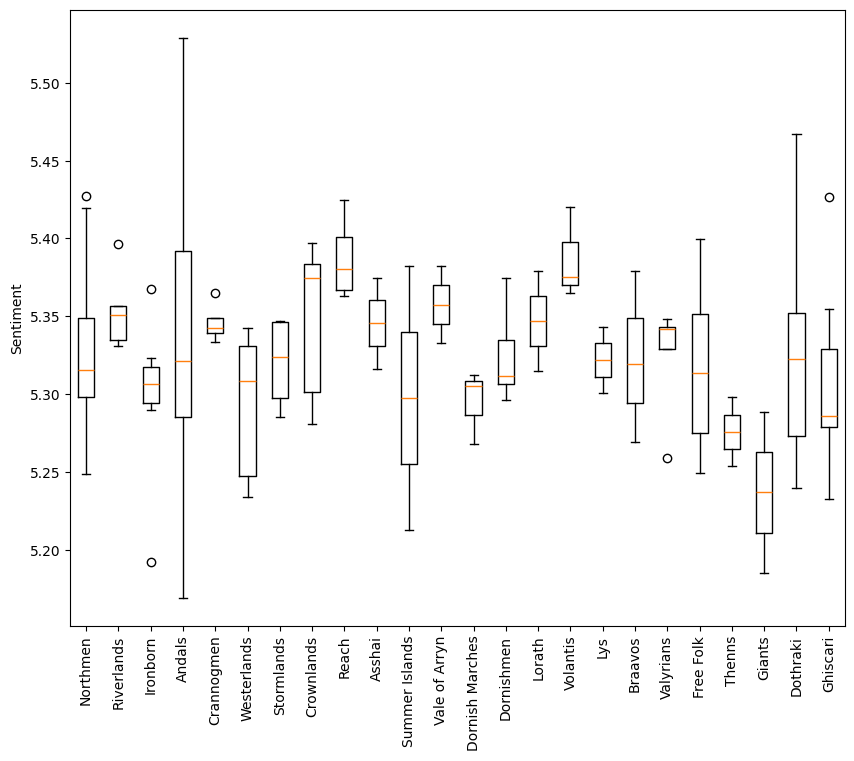

In [125]:
plt.figure(figsize=(10, 8))
plt.boxplot([culture_sentiments[culture] for culture in cultures_list_1])
plt.xticks(np.arange(1, len(cultures_list_1)+1), cultures_list_1, rotation=90)
plt.ylabel('Sentiment')
plt.show()


We see that the culture with the highest average sentiment score is the Reach with an average sentiment score of 5.39 and the culture with the lowest average sentiment score is the Giants with an average sentiment score of 5.24. We also see that the culture with the highest standard deviation is the Northmen with a standard deviation of 0.0440 and the culture with the lowest standard deviation is the Ghiscari with a standard deviation of 0.0589.

Again we do a label shuffeling test to test if the sentiment scores of the culture with the lowest score is significatly different than a random group of characters of the same size as the culture. We do the same for the culture with the highest score.

In [126]:
np.random.seed(42)
highest_culture = list(culture_avg_sentiment.keys())[0]
highest_culture_sentiment = culture_avg_sentiment[highest_culture]
num_highest = culture_sizes[highest_culture]
print(f'Highest culture sentiment: {highest_culture_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_highest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_highest
    avg_random_sentiment += random_sentiment

    if random_sentiment > highest_culture_sentiment:
        count += 1
print(f'Fraction of randomly selected groups higher sentiment than the highest culture: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Highest culture sentiment: 5.387168193793721
Fraction of randomly selected groups higher sentiment than the highest culture: 0.033
Average random sentiment: 5.328085775432295


In [127]:
np.random.seed(42)
lowest_culture = list(culture_avg_sentiment.keys())[-1]
lowest_culture_sentiment = culture_avg_sentiment[lowest_culture]
num_lowest = culture_sizes[lowest_culture]
print(f'Lowest culture sentiment: {lowest_culture_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_lowest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_lowest
    avg_random_sentiment += random_sentiment

    if random_sentiment < lowest_culture_sentiment:
        count += 1
print(f'Fraction of randomly selected groups lower sentiment than the lowest culture: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Lowest culture sentiment: 5.236970698942176
Fraction of randomly selected groups lower sentiment than the lowest culture: 0.018
Average random sentiment: 5.330398474167001


Again we see that with a significance level of 5% the sentiment scores of the cultures are significantly different than a random group of characters of the same size as the culture. 

We do the same analysis for the religions.

In [128]:
religion_sentiments = {}
religion_avg_sentiment = {}
religion_std_sentiment = {}

# initialize house sentiments and size to 0
for religion in religions_list:
    religion_sentiments[religion] = []

# Calculate the total sentiment
for node, attributes in di_G_with_religions.nodes(data=True):
    religion = attributes['religion']
    religion_sentiments[religion].append(sentiments[node])

# Calculate the average sentiment
for religion in religions_list_1:
    religion_avg_sentiment[religion] = np.mean(religion_sentiments[religion])
    religion_std_sentiment[religion] = np.std(religion_sentiments[religion])
    G_religions.nodes[religion]['sentiment'] = religion_avg_sentiment[religion]

religion_avg_sentiment = dict(sorted(religion_avg_sentiment.items(), key=lambda x: x[1], reverse=True))
mean_std_religion = np.mean(list(religion_std_sentiment.values()))
std_avg_religion = np.std(list(religion_avg_sentiment.values()))

print(f'religions average sentiment: {religion_avg_sentiment}')
print(f'religions std sentiment: {religion_std_sentiment}')

religions average sentiment: {"R'hllor": 5.345596834314828, 'Faith of the Seven': 5.34057746990044, 'Old Gods of the Forest': 5.324302629168284, 'Great Stallion': 5.322957853108701, 'Great Shepherd': 5.310309389713328, 'Many-Faced God': 5.300979816004086, 'Drowned God': 5.299376138622241, 'Ghiscari religion': 5.2890936981456385}
religions std sentiment: {'Old Gods of the Forest': 0.05167149572587169, 'Faith of the Seven': 0.07684670978638096, 'Drowned God': 0.04955190595165383, "R'hllor": 0.061073669239954914, 'Many-Faced God': 0.02255336789082312, 'Great Stallion': 0.06684775281372374, 'Great Shepherd': 0.010169333690920546, 'Ghiscari religion': 0.036500349247415194}


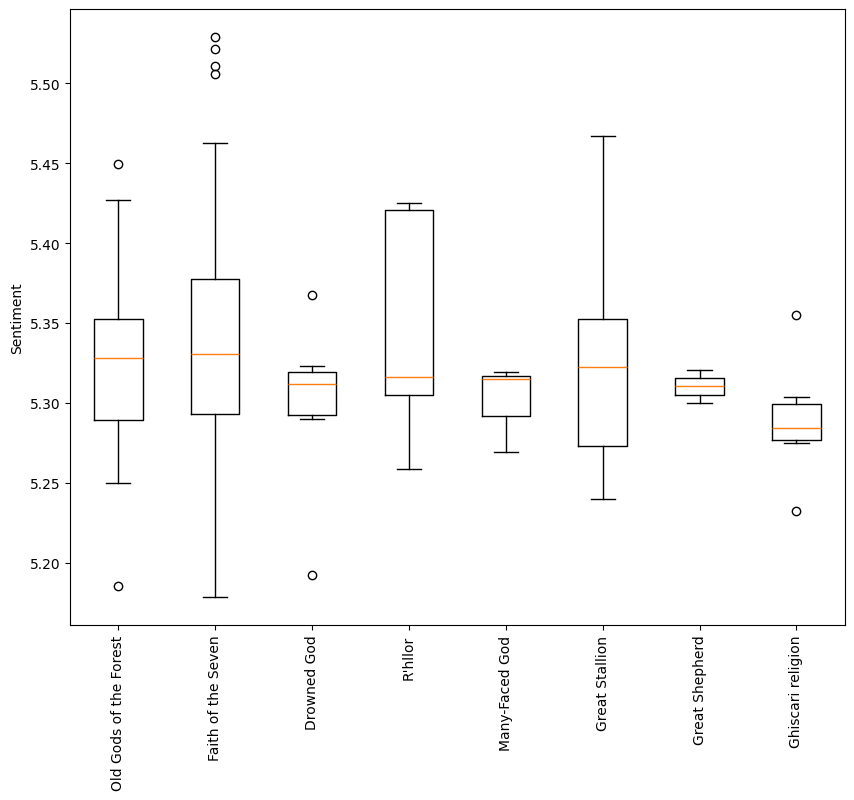

In [129]:
plt.figure(figsize=(10, 8))
plt.boxplot([religion_sentiments[religion] for religion in religions_list_1])
plt.xticks(np.arange(1, len(religions_list_1)+1), religions_list_1, rotation=90)
plt.ylabel('Sentiment')
plt.show()

We see that the religion with the highest average sentiment score is the R'hllor with an average sentiment score of 5.35 and the religion with the lowest average sentiment score is the Ghiscari religion with an average sentiment score of 5.29. We also see that the religion with the highest standard deviation is the Old Gods of the Forest with a standard deviation of 0.0517 and the religion with the lowest standard deviation is the Ghiscari religion with a standard deviation of 0.0365.

Again we do a label shuffeling test to test if the sentiment scores of the religion with the lowest score is significatly different than a random group of characters of the same size as the religion. We do the same for the religion with the highest score.

In [130]:
np.random.seed(42)
highest_religion = list(religion_avg_sentiment.keys())[0]
highest_religion_sentiment = religion_avg_sentiment[highest_religion]
num_highest = religion_sizes[highest_religion]
print(f'Highest religion sentiment: {highest_religion_sentiment}')

count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_highest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_highest
    avg_random_sentiment += random_sentiment

    if random_sentiment > highest_religion_sentiment:
        count += 1
print(f'Fraction of randomly selected groups higher sentiment than the highest culture: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Highest religion sentiment: 5.345596834314828
Fraction of randomly selected groups higher sentiment than the highest culture: 0.229
Average random sentiment: 5.330223382074517


In [131]:
np.random.seed(42)
lowest_religion = list(religion_avg_sentiment.keys())[-1]
lowest_religion_sentiment = religion_avg_sentiment[lowest_religion]
num_lowest = religion_sizes[lowest_religion]
print(f'Lowest religion sentiment: {lowest_religion_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_lowest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_lowest
    avg_random_sentiment += random_sentiment

    if random_sentiment < lowest_religion_sentiment:
        count += 1
print(f'Fraction of randomly selected groups lower sentiment than the lowest religion: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Lowest religion sentiment: 5.2890936981456385
Fraction of randomly selected groups lower sentiment than the lowest religion: 0.049
Average random sentiment: 5.330317259825469


Now here we see that with a significance level of 5% the sentiment scores of the religion with the highest senitment score is not significantly higher than a random group of characters of the same size as the religion and the the religion with the lowest sentiment score is only just significatly lower than a ranodom group of characters of the same size as the religion. 

Finally we do the same analysis for the communities obtained by the Louvain algorithm.

In [132]:
# calculate the sentiment scores of the best_partition communities
best_partition_sentiments = {}
best_partition_avg_sentiment = {}
best_partition_std_sentiment = {}

# initialize house sentiments and size to 0
for best_part in set(best_partition.values()):
    best_partition_sentiments[best_part] = []

# Calculate the total sentiment
for node, attributes in di_G.nodes(data=True):
    best_part = best_partition[node]
    best_partition_sentiments[best_part].append(sentiments[node])

# Calculate the average sentiment
for best_part in set(best_partition.values()):
    best_partition_avg_sentiment[best_part] = np.mean(best_partition_sentiments[best_part])
    best_partition_std_sentiment[best_part] = np.std(best_partition_sentiments[best_part])

best_partition = dict(sorted(best_partition.items(), key=lambda x: x[1], reverse=True))

mean_std_best_partition = np.mean(list(best_partition_std_sentiment.values()))
std_avg_best_partition = np.std(list(best_partition_avg_sentiment.values()))

best_partition_avg_sentiment = dict(sorted(best_partition_avg_sentiment.items(), key=lambda x: x[1], reverse=True))
best_partition_std_sentiment = dict(sorted(best_partition_std_sentiment.items(), key=lambda x: x[1], reverse=True))

print(f'best partition average sentiment: {best_partition_avg_sentiment}')
print(f'best partition std sentiment: {best_partition_std_sentiment}')


best partition average sentiment: {0: 5.348817290993421, 4: 5.343259244545621, 1: 5.3419328360961, 5: 5.328513398798143, 2: 5.320951083075499, 3: 5.277523838215644}
best partition std sentiment: {3: 0.0755422340194829, 5: 0.06701802221481132, 4: 0.06396764222670487, 2: 0.054015588048002834, 1: 0.053716207115429876, 0: 0.036575068050743946}


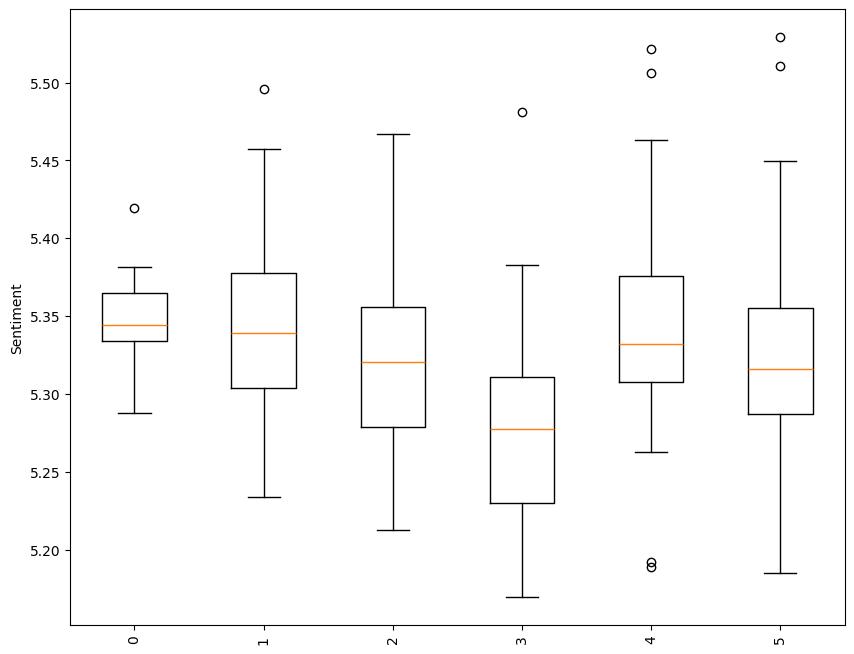

In [133]:
plt.figure(figsize=(10, 8))
plt.boxplot([best_partition_sentiments[best_part] for best_part in set(best_partition.values())])
plt.xticks(np.arange(1, len(set(best_partition.values()))+1), set(best_partition.values()), rotation=90)
plt.ylabel('Sentiment')
plt.show()


Here we se that the community with the highest average sentiment score is community 0 with an average sentiment score of 5.35 and the community with the lowest average sentiment score is community 3 with an average sentiment score of 5.28. We also see that the community with the highest standard deviation is community 3 with a standard deviation of 0.0755 and the community with the lowest standard deviation is community 0 with a standard deviation of 0.0366.

Again we do a label shuffeling test to test if the sentiment scores of the community with the lowest score is significatly different than a random group of characters of the same size as the community. We do the same for the community with the highest score.

In [134]:
np.random.seed(42)
highest_best_partition = list(best_partition_avg_sentiment.keys())[0]
highest_best_partition_sentiment = best_partition_avg_sentiment[highest_best_partition]
num_highest = best_partition_sizes[highest_best_partition]
print(f'Highest best_partition sentiment: {highest_best_partition_sentiment}')

count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_highest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_highest
    avg_random_sentiment += random_sentiment

    if random_sentiment > highest_best_partition_sentiment:
        count += 1
        
print(f'Fraction of randomly selected groups higher sentiment than the highest best_partition: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Highest best_partition sentiment: 5.348817290993421
Fraction of randomly selected groups higher sentiment than the highest best_partition: 0.173
Average random sentiment: 5.329664979137518


In [135]:
np.random.seed(42)
lowest_best_partition = list(best_partition_avg_sentiment.keys())[-1]
lowest_best_partition_sentiment = best_partition_avg_sentiment[lowest_best_partition]
num_lowest = best_partition_sizes[lowest_best_partition]
print(f'Lowest best_partition sentiment: {lowest_best_partition_sentiment}')
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_lowest):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_lowest
    avg_random_sentiment += random_sentiment

    if random_sentiment < lowest_best_partition_sentiment:
        count += 1
        
print(f'Fraction of randomly selected groups lower sentiment than the lowest best_partition: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Lowest best_partition sentiment: 5.277523838215644
Fraction of randomly selected groups lower sentiment than the lowest best_partition: 0.0
Average random sentiment: 5.329367728823615


Again we see that with a significance level of 5% the sentiment scores of the community with the highest senitment score is not significantly higher than a random group of characters of the same size as the community, however the community with the lowest sentiment score is only significatly lower than a ranodom group of characters of the same size as the community.

In [136]:
# print all the mean stds

print(f'Standard deviation of the average sentiment of the houses: {std_avg_houses}')
print(f'Mean standard deviation of the houses: {mean_std_houses}')
print(f'Number of houses in the analysis: {len(houses_list_1)}')
print('\n')
print(f'Standard deviation of the average sentiment of the cultures: {std_avg_culture}')
print(f'Mean standard deviation of the cultures: {mean_std_culture}')
print(f'Number of cultures in the analysis: {len(cultures_list_1)}')
print('\n')
print(f'Standard deviation of the average sentiment of the religions: {std_avg_religion}')
print(f'Mean standard deviation of the religions: {mean_std_religion}')
print(f'Number of religions in the analysis: {len(religions_list_1)}')
print('\n')
print(f'Standard deviation of the average sentiment of the best partition: {std_avg_best_partition}')
print(f'Mean standard deviation of the best partition: {mean_std_best_partition}')
print(f'Number of communities in the analysis: {len(set(best_partition.values()))}')


Standard deviation of the average sentiment of the houses: 0.05552449508236632
Mean standard deviation of the houses: 0.03338995577431954
Number of houses in the analysis: 23


Standard deviation of the average sentiment of the cultures: 0.032523952822133405
Mean standard deviation of the cultures: 0.039392430167432345
Number of cultures in the analysis: 24


Standard deviation of the average sentiment of the religions: 0.018882163660497695
Mean standard deviation of the religions: 0.046901823043343
Number of religions in the analysis: 8


Standard deviation of the average sentiment of the best partition: 0.02397898292662593
Mean standard deviation of the best partition: 0.05847246027919597
Number of communities in the analysis: 6


If we look at the standard deviation of the average sentiment scores in the different community splits we see that the standard deviation is highest for the houses and lowest for the religions. Looking at the mean of the standard deviations we see that the mean standard deviation is highest for the communities obtained by the Louvain algorthm followed by the religions and lowest for the houses.

This indicates that the average sentiment scores of the houses vary a lot from each other, but the average sentiment scores of the characters in the house do not vary a lot from each other. The opposite is true for the religions. The average sentiment scores of the characters in the religions do vary a lot from each other and the average sentiment scores of the religions do not vary a lot from each other.

Overall this indicates that the house the character belongs to is a better indicator of the sentiment of the character than the religion the character belongs to.


In [137]:
# nodes sizes are the size of the house/religion/culture
# edge sizes are the weights
# node colors are in the range from green to red based on the sentiment
cmap = plt.get_cmap('RdYlGn')

nodes_sentiments = [G_houses.nodes[node]['sentiment'] for node in G_houses.nodes()]
nodes_sentiments_norm = nodes_sentiments-np.min(nodes_sentiments)
nodes_sentiments_norm /=np.max(nodes_sentiments_norm)
node_colors_houses = [cmap(x) for x in nodes_sentiments_norm]

nodes_sentiments = [G_religions.nodes[node]['sentiment'] for node in G_religions.nodes()]
nodes_sentiments_norm = nodes_sentiments-np.min(nodes_sentiments)
nodes_sentiments_norm /=np.max(nodes_sentiments_norm)
node_colors_religions = [cmap(x) for x in nodes_sentiments_norm]

nodes_sentiments = [G_cultures.nodes[node]['sentiment'] for node in G_cultures.nodes()]
nodes_sentiments_norm = nodes_sentiments-np.min(nodes_sentiments)
nodes_sentiments_norm /=np.max(nodes_sentiments_norm)
node_colors_cultures = [cmap(x) for x in nodes_sentiments_norm]


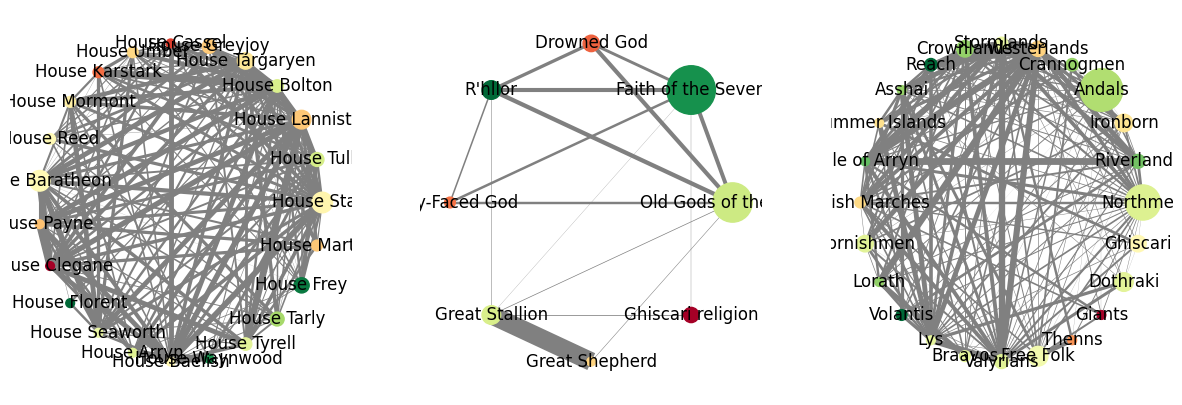

In [138]:

fig, ax = plt.subplots(1,3, figsize=(15,5))
nx.draw(G_houses, pos_houses, node_size=node_sizes_houses, node_color=node_colors_houses, width=edge_sizes_houses, with_labels=True, edge_color=edge_colors_houses, ax=ax[0])

nx.draw(G_religions, pos_religions, node_size=node_sizes_religions, node_color=node_colors_religions, width=edge_sizes_religions, with_labels=True, edge_color=edge_colors_religions, ax=ax[1])

nx.draw(G_cultures, pos_cultures, node_size=node_sizes_cultures, node_color=node_colors_cultures, width=edge_sizes_cultures, with_labels=True, edge_color=edge_colors_cultures, ax=ax[2])
plt.show()


In [139]:
avg_diff_houses = 0
for house in G_houses.nodes():
    avg_diff_houses += sentiment_difference(G_houses, house)
avg_diff_houses /= len(G_houses.nodes())
print(f'Average sentiment difference between houses and the houses they connect to: {avg_diff_houses}')

avg_diff_religions = 0
for religion in G_religions.nodes():
    avg_diff_religions += sentiment_difference(G_religions, religion)
avg_diff_religions /= len(G_religions.nodes())
print(f'Average sentiment difference between religion and the religions they connect to: {avg_diff_religions}')

avg_diff_cultures = 0
for culture in G_cultures.nodes():
    avg_diff_cultures += sentiment_difference(G_cultures, culture)
avg_diff_cultures /= len(G_cultures.nodes())
print(f'Average sentiment difference between cultures and the cultures they connect to: {avg_diff_cultures}')


Average sentiment difference between houses and the houses they connect to: 0.013636231828452687
Average sentiment difference between religion and the religions they connect to: 0.00172855139896063
Average sentiment difference between cultures and the cultures they connect to: 0.0068303266090228515


In [140]:
# get raw text from all characters in lowest_house
lowest_house_file_names = []
highest_house_file_names = []
lowest_culture_file_names = []
highest_culture_file_names = []
lowest_religion_file_names = []
highest_religion_file_names = []
for node, attributes in di_G.nodes(data=True):
    houses = attributes['houses'].split(', ')
    culture = attributes['culture']
    religion = attributes['religion']
    file_name = node + '.txt'
    if lowest_house in houses:
        lowest_house_file_names.append(file_name)
    elif highest_house in houses:
        highest_house_file_names.append(file_name)
    if lowest_culture == culture:
        lowest_culture_file_names.append(file_name)
    elif highest_culture == culture:
        highest_culture_file_names.append(file_name)
    if lowest_religion == religion:
        lowest_religion_file_names.append(file_name)
    elif highest_religion == religion:
        highest_religion_file_names.append(file_name)


lowest_character_corpus = PlaintextCorpusReader('files/wiki_texts', lowest_character+ '.txt')

highest_character_corpus = PlaintextCorpusReader('files/wiki_texts', highest_character+ '.txt')

lowest_character_raw = lowest_character_corpus.raw()
highest_character_raw = highest_character_corpus.raw()

print(f'Lowest character sentiment text lenght: {len(lowest_character_raw)}')
print(f'Highest character sentiment text lenght: {len(highest_character_raw)}')

lowest_house_corpus = PlaintextCorpusReader('files/wiki_texts', lowest_house_file_names)

highest_house_corpus = PlaintextCorpusReader('files/wiki_texts', highest_house_file_names)

lowest_house_raw = lowest_house_corpus.raw()
highest_house_raw = highest_house_corpus.raw()

print(f'Lowest house sentiment text lenght: {len(lowest_house_raw)}')
print(f'Highest house sentiment text lenght: {len(highest_house_raw)}')

lowest_culture_corpus = PlaintextCorpusReader('files/wiki_texts', lowest_culture_file_names)

highest_culture_corpus = PlaintextCorpusReader('files/wiki_texts', highest_culture_file_names)

lowest_culture_raw = lowest_culture_corpus.raw()
highest_culture_raw = highest_culture_corpus.raw()

print(f'Lowest culture sentiment text lenght: {len(lowest_culture_raw)}')
print(f'Highest culture sentiment text lenght: {len(highest_culture_raw)}')

lowest_religion_corpus = PlaintextCorpusReader('files/wiki_texts', lowest_religion_file_names)
highest_religion_corpus = PlaintextCorpusReader('files/wiki_texts', highest_religion_file_names)

lowest_religion_raw = lowest_religion_corpus.raw()
highest_religion_raw = highest_religion_corpus.raw()

print(f'Lowest religion sentiment text lenght: {len(lowest_religion_raw)}')
print(f'Highest religion sentiment text lenght: {len(highest_religion_raw)}')


Lowest character sentiment text lenght: 9955
Highest character sentiment text lenght: 4217
Lowest house sentiment text lenght: 119607
Highest house sentiment text lenght: 23084
Lowest culture sentiment text lenght: 16135
Highest culture sentiment text lenght: 175561
Lowest religion sentiment text lenght: 58605
Highest religion sentiment text lenght: 232437


In [141]:
dict_lowest_character_TFTR, dict_highest_character_TFTR, fdist_lowest_character, fdist_highest_character = get_TFTR(lowest_character_raw, highest_character_raw, c = 1)

dict_lowest_character_TFTR_weighted, dict_highest_character_TFTR_weighted, _, _ = get_TFTR(lowest_character_raw, highest_character_raw, c = 1, weighted=True)

min_lowest_character_TFTR = min(dict_lowest_character_TFTR.values())
min_highest_character_TFTR = min(dict_highest_character_TFTR.values())
min_lowest_character_TFTR_weighted = min(dict_lowest_character_TFTR_weighted.values())
min_highest_character_TFTR_weighted = min(dict_highest_character_TFTR_weighted.values())

print("Top 5 words in the text from the characters with lowest sentiment")
for i, w in enumerate(fdist_lowest_character):
    if i >= 10:
        break
    print(w, fdist_lowest_character[w])

print("\nTop 5 words in the text from the characters with highest sentiment")
for i, w in enumerate(fdist_highest_character):
    if i >= 10:
        break
    print(w, fdist_highest_character[w])

print("\nTop 5 TF-TR scores in the text from the characters with lowest sentiment")
for i, w in enumerate(dict_lowest_character_TFTR):
    if i >= 10:
        break
    print(w, dict_lowest_character_TFTR[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest sentiment")
for i, w in enumerate(dict_highest_character_TFTR):
    if i >= 10:
        break
    print(w, dict_highest_character_TFTR[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest sentiment")
for i, w in enumerate(dict_lowest_character_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_character_TFTR_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest sentiment")
for i, w in enumerate(dict_highest_character_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_highest_character_TFTR_weighted[w])


Top 5 words in the text from the characters with lowest sentiment
polliver 48
hound 27
arya 19
says 15
lommy 11
thrones 9
lannister 8
season 8
needle 8
game 8

Top 5 words in the text from the characters with highest sentiment
tarly 22
talla 15
house 9
randyll 9
gilly 9
horn 8
blood 7
samwell 7
game 7
thrones 7

Top 5 TF-TR scores in the text from the characters with lowest sentiment
polliver 2304.0
hound 729.0
arya 361.0
lommy 121.0
says 112.5
lannister 64.0
needle 64.0
asks 64.0
lorch 49.0
men 49.0

Top 5 TF-TR scores in the text from the characters with highest sentiment
tarly 484.0
talla 225.0
randyll 81.0
gilly 81.0
horn 64.0
samwell 49.0
hill 36.0
sam 36.0
dickon 25.0
melessa 16.0

Top 5 weighted TF-TR scores in the text from the characters with lowest sentiment
polliver 403.00186564547136
hound 127.5123090518874
arya 63.143955511291296
lommy 21.164594506554696
says 19.67782547097028
lannister 11.194496267929757
needle 11.194496267929757
asks 11.194496267929757
lorch 8.5707862051

In [142]:
lowest_character_str = ""
highest_character_str = ""

for w in dict_lowest_character_TFTR:
    for i in range(int(dict_lowest_character_TFTR[w]/min_lowest_character_TFTR)):
        lowest_character_str += w + " "

for w in dict_highest_character_TFTR:
    for i in range(int(dict_highest_character_TFTR[w]/min_highest_character_TFTR)):
        highest_character_str += w + " "

lowest_character_str_weighted = ""
highest_character_str_weighted = ""
for w in dict_lowest_character_TFTR_weighted:
    for i in range(int(dict_lowest_character_TFTR_weighted[w]/min_lowest_character_TFTR_weighted)):
        lowest_character_str_weighted += w + " "

for w in dict_highest_character_TFTR_weighted:
    for i in range(int(dict_highest_character_TFTR_weighted[w]/min_highest_character_TFTR_weighted)):
        highest_character_str_weighted += w + " "


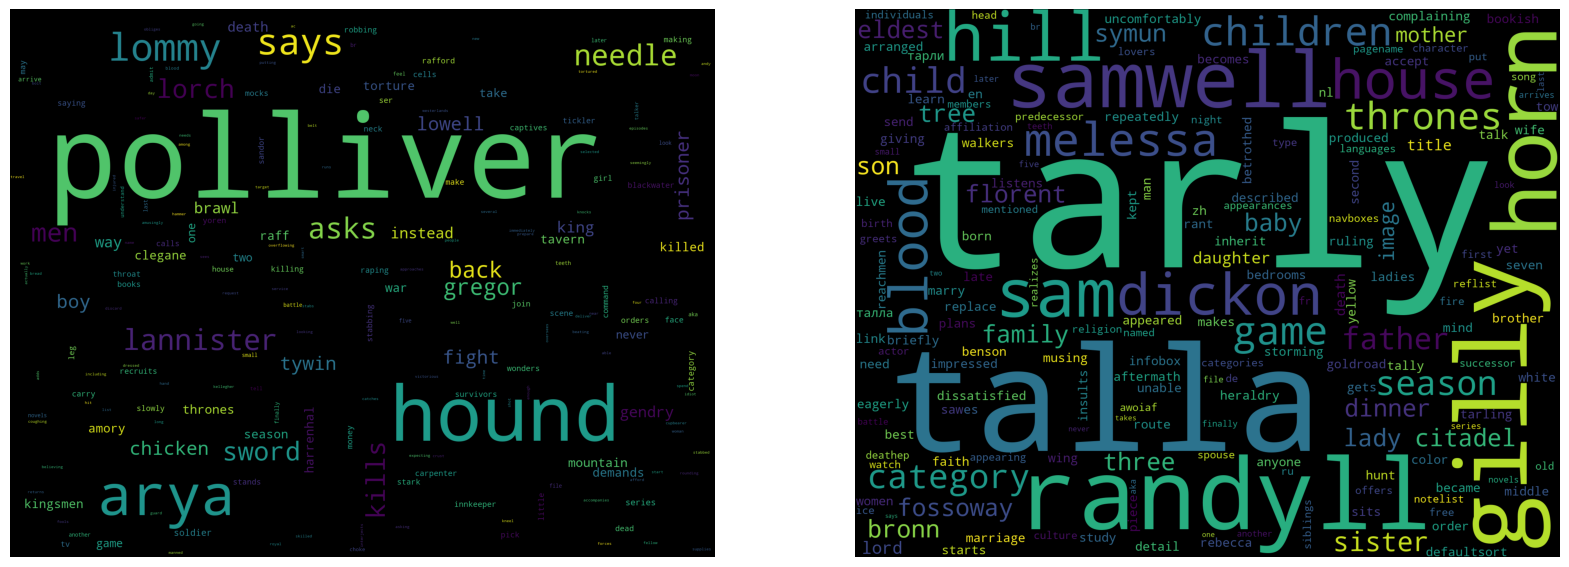

In [143]:
lowest_character_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_character_str_weighted)

highest_character_weighted_wordcloud = WordCloud(
                        stopwords=STOPWORDS,
                        background_color='black',
                        width=1800,
                        height=1400,
                        collocations = False
                         ).generate(highest_character_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_character_weighted_wordcloud)
ax[0].axis('off')
ax[1].imshow(highest_character_weighted_wordcloud)
ax[1].axis('off')
plt.show()


In [144]:
dict_lowest_character_TFTR_sentiment, dict_highest_character_TFTR_sentiment, fdist_lowest_character_sentiment, fdist_highest_character_sentiment = get_TFTR(lowest_character_raw, highest_character_raw, c = 1, sentiment_words=dict_avg_sentiments)

dict_lowest_character_TFTR_sentiment_weighted, dict_highest_character_TFTR_sentiment_weighted, _, _ = get_TFTR(lowest_character_raw, highest_character_raw, c = 1, weighted=True, sentiment_words=dict_avg_sentiments)

min_lowest_character_TFTR_sentiment = min(dict_lowest_character_TFTR_sentiment.values())
min_highest_character_TFTR_sentiment = min(dict_highest_character_TFTR_sentiment.values())
min_lowest_character_TFTR_sentiment_weighted = min(dict_lowest_character_TFTR_sentiment_weighted.values())
min_highest_character_TFTR_sentiment_weighted = min(dict_highest_character_TFTR_sentiment_weighted.values())

print("Top 5 words in the text from the characters with lowest sentiment")
for i, w in enumerate(fdist_lowest_character_sentiment):
    if i >= 10:
        break
    print(w, fdist_lowest_character_sentiment[w])

print("\nTop 5 words in the text from the characters with highest sentiment")
for i, w in enumerate(fdist_highest_character_sentiment):
    if i >= 10:
        break
    print(w, fdist_highest_character_sentiment[w])

print("\nTop 5 TF-TR scores in the text from the characters with lowest sentiment")
for i, w in enumerate(dict_lowest_character_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_lowest_character_TFTR_sentiment[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest sentiment")
for i, w in enumerate(dict_highest_character_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_highest_character_TFTR_sentiment[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest sentiment")
for i, w in enumerate(dict_lowest_character_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_character_TFTR_sentiment_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest sentiment")
for i, w in enumerate(dict_highest_character_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_highest_character_TFTR_sentiment_weighted[w])


Top 5 words in the text from the characters with lowest sentiment
hound 27
says 15
season 8
needle 8
game 8
asks 8
men 7
kills 7
house 6
back 6

Top 5 words in the text from the characters with highest sentiment
house 9
horn 8
blood 7
game 7
hill 6
season 6
sam 6
category 5
children 4
father 3

Top 5 TF-TR scores in the text from the characters with lowest sentiment
hound 729.0
says 112.5
needle 64.0
asks 64.0
men 49.0
kills 49.0
back 36.0
fight 25.0
boy 25.0
prisoners 25.0

Top 5 TF-TR scores in the text from the characters with highest sentiment
horn 64.0
hill 36.0
sam 36.0
blood 12.25
house 11.571428571428573
child 9.0
children 8.0
game 5.444444444444445
father 4.5
category 4.166666666666667

Top 5 weighted TF-TR scores in the text from the characters with lowest sentiment
hound 111.28821612561686
says 17.174107426792727
needle 9.770158891686528
asks 9.770158891686528
men 7.480277901447496
kills 7.480277901447496
back 5.495714376573671
fight 3.8164683170650497
boy 3.8164683170650497

In [145]:
lowest_character_sentiment_str = ""
highest_character_sentiment_str = ""

for w in dict_lowest_character_TFTR_sentiment:
    for i in range(int(dict_lowest_character_TFTR_sentiment[w]/min_lowest_character_TFTR_sentiment)):
        lowest_character_sentiment_str += w + " "

for w in dict_highest_character_TFTR_sentiment:
    for i in range(int(dict_highest_character_TFTR_sentiment[w]/min_highest_character_TFTR_sentiment)):
        highest_character_sentiment_str += w + " "

lowest_character_sentiment_str_weighted = ""
highest_character_sentiment_str_weighted = ""
for w in dict_lowest_character_TFTR_sentiment_weighted:
    for i in range(int(dict_lowest_character_TFTR_sentiment_weighted[w]/min_lowest_character_TFTR_sentiment_weighted)):
        lowest_character_sentiment_str_weighted += w + " "

for w in dict_highest_character_TFTR_sentiment_weighted:
    for i in range(int(dict_highest_character_TFTR_sentiment_weighted[w]/min_highest_character_TFTR_sentiment_weighted)):
        highest_character_sentiment_str_weighted += w + " "


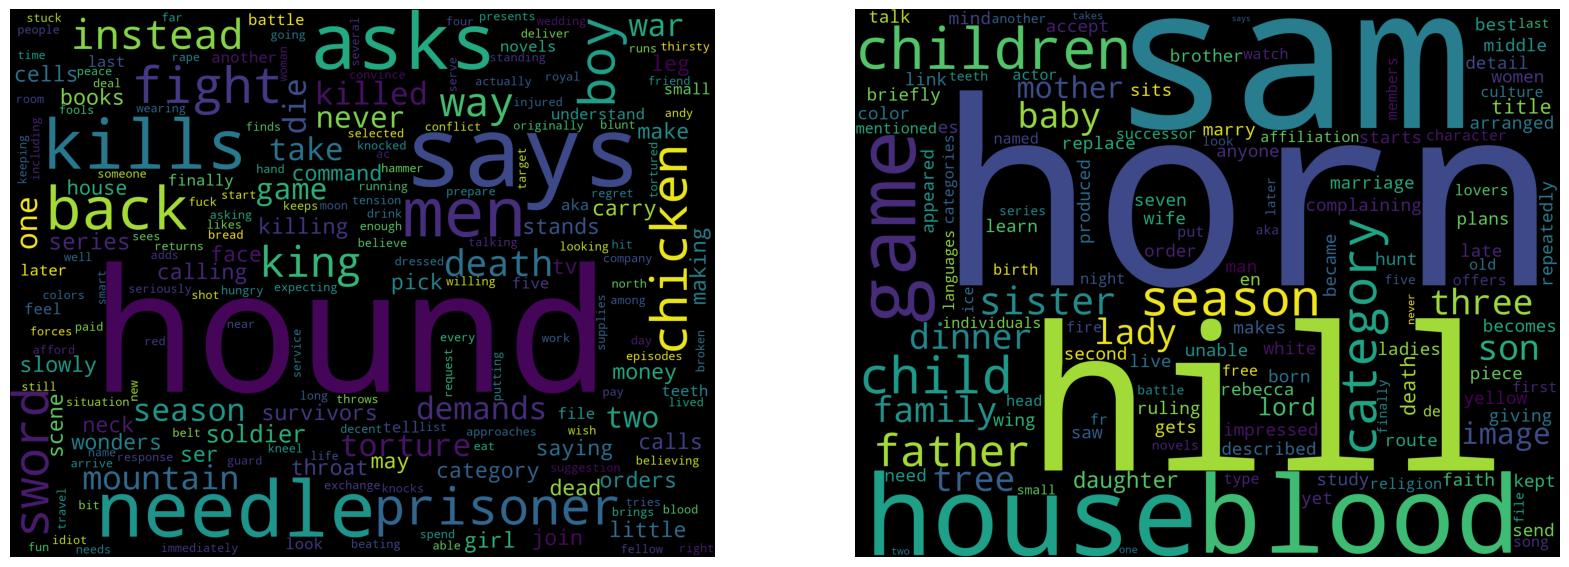

In [146]:

lowest_character_sentiment_weighted_wordcloud = WordCloud(
                        stopwords=STOPWORDS,
                        background_color='black',
                        width=1800,
                        height=1400,
                        collocations = False
                         ).generate(lowest_character_sentiment_str_weighted)

highest_character_sentiment_weighted_wordcloud = WordCloud(
                        stopwords=STOPWORDS,
                        background_color='black',
                        width=1800,
                        height=1400,
                        collocations = False
                         ).generate(highest_character_sentiment_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_character_sentiment_weighted_wordcloud)
ax[0].axis('off')
ax[1].imshow(highest_character_sentiment_weighted_wordcloud)
ax[1].axis('off')
plt.show()

In [147]:
dict_lowest_house_TFTR, dict_highest_house_TFTR, fdist_lowest_house, fdist_highest_house = get_TFTR(lowest_house_raw, highest_house_raw, c = 1)

dict_lowest_house_TFTR_weighted, dict_highest_house_TFTR_weighted, _, _ = get_TFTR(lowest_house_raw, highest_house_raw, c = 1, weighted=True)

min_lowest_house_TFTR = min(dict_lowest_house_TFTR.values())
min_highest_house_TFTR = min(dict_highest_house_TFTR.values())
min_lowest_house_TFTR_weighted = min(dict_lowest_house_TFTR_weighted.values())
min_highest_house_TFTR_weighted = min(dict_highest_house_TFTR_weighted.values())

print("Top 5 words in the text from the characters with lowest houses")
for i, w in enumerate(fdist_lowest_house):
    if i >= 10:
        break
    print(w, fdist_lowest_house[w])

print("\nTop 5 words in the text from the characters with highest house")
for i, w in enumerate(fdist_highest_house):
    if i >= 10:
        break
    print(w, fdist_highest_house[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with lowest house")
for i, w in enumerate(dict_lowest_house_TFTR):
    if i >= 10:
        break
    print(w, dict_lowest_house_TFTR[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest house")
for i, w in enumerate(dict_highest_house_TFTR):
    if i >= 10:
        break
    print(w, dict_highest_house_TFTR[w])


print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest houses")
for i, w in enumerate(dict_lowest_house_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_house_TFTR_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest house")
for i, w in enumerate(dict_highest_house_TFTR_weighted):
    if i >= 10:
        break
    print(w, dict_highest_house_TFTR_weighted[w])
    

Top 5 words in the text from the characters with lowest houses
sandor 319
gregor 242
arya 133
clegane 117
cersei 101
season 86
file 71
brother 60
thrones 59
king 58

Top 5 words in the text from the characters with highest house
selyse 64
stannis 45
house 33
baratheon 31
season 31
thrones 26
game 25
melisandre 25
shireen 23
florent 20

Top 5 TF-TR scores in the text from the characters with lowest house
sandor 101761.0
gregor 58564.0
arya 17689.0
clegane 13689.0
cersei 10201.0
man 3136.0
hound 3025.0
sansa 1936.0
lannister 1849.0
beric 1764.0

Top 5 TF-TR scores in the text from the characters with highest house
selyse 4096.0
shireen 529.0
stannis 405.0
florent 400.0
melessa 324.0
tarly 200.0
gilly 144.0
wife 121.0
melisandre 89.28571428571429
stillborn 81.0

Top 5 weighted TF-TR scores in the text from the characters with lowest houses
sandor 3340.598331896709
gregor 1922.5322147895447
arya 580.6924449732303
clegane 449.3809078658234
cersei 334.8772475081645
man 102.94824509220703
hou

In [148]:
lowest_house_str = ""
highest_house_str = ""

for w in dict_lowest_house_TFTR:
    for i in range(int(dict_lowest_house_TFTR[w]/min_lowest_house_TFTR)):
        lowest_house_str += w + " "

for w in dict_highest_house_TFTR:
    for i in range(int(dict_highest_house_TFTR[w]/min_highest_house_TFTR)):
        highest_house_str += w + " "

lowest_house_str_weighted = ""
highest_house_str_weighted = ""
for w in dict_lowest_house_TFTR_weighted:
    for i in range(int(dict_lowest_house_TFTR_weighted[w]/min_lowest_house_TFTR_weighted)):
        lowest_house_str_weighted += w + " "

for w in dict_highest_house_TFTR_weighted:
    for i in range(int(dict_highest_house_TFTR_weighted[w]/min_highest_house_TFTR_weighted)):
        highest_house_str_weighted += w + " "

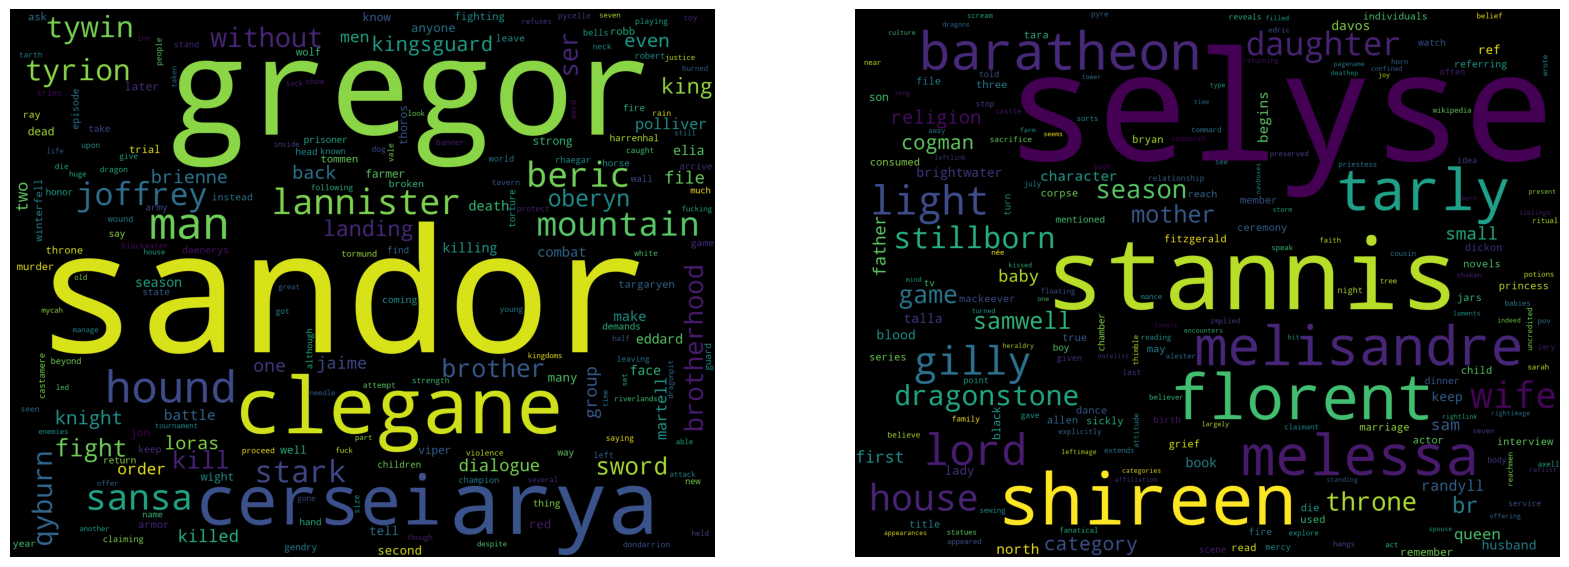

In [149]:
lowest_house_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_house_str_weighted)
                     
highest_house_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(highest_house_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_house_weighted_wordcloud)
ax[0].axis('off')
ax[1].imshow(highest_house_weighted_wordcloud)
ax[1].axis('off')
plt.show()

In [150]:
dict_lowest_house_TFTR_sentiment, dict_highest_house_TFTR_sentiment, fdist_lowest_house_sentiment, fdist_highest_house_sentiment = get_TFTR(lowest_house_raw, highest_house_raw, c = 1, sentiment_words=dict_avg_sentiments)

dict_lowest_house_TFTR_sentiment_weighted, dict_highest_house_TFTR_sentiment_weighted, _, _ = get_TFTR(lowest_house_raw, highest_house_raw, c = 1, weighted=True, sentiment_words=dict_avg_sentiments)

min_lowest_house_TFTR_sentiment = min(dict_lowest_house_TFTR_sentiment.values())
min_highest_house_TFTR_sentiment = min(dict_highest_house_TFTR_sentiment.values())
min_lowest_house_TFTR_sentiment_weighted = min(dict_lowest_house_TFTR_sentiment_weighted.values())
min_highest_house_TFTR_sentiment_weighted = min(dict_highest_house_TFTR_sentiment_weighted.values())

print("Top 5 words in the text from the characters with lowest houses")
for i, w in enumerate(fdist_lowest_house_sentiment):
    if i >= 10:
        break
    print(w, fdist_lowest_house_sentiment[w])

print("\nTop 5 words in the text from the characters with highest house")
for i, w in enumerate(fdist_highest_house_sentiment):
    if i >= 10:
        break
    print(w, fdist_highest_house_sentiment[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with lowest house")
for i, w in enumerate(dict_lowest_house_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_lowest_house_TFTR_sentiment[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest house")
for i, w in enumerate(dict_highest_house_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_highest_house_TFTR_sentiment[w])


print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest houses")
for i, w in enumerate(dict_lowest_house_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_house_TFTR_sentiment_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest house")
for i, w in enumerate(dict_highest_house_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_highest_house_TFTR_sentiment_weighted[w])
    

Top 5 words in the text from the characters with lowest houses
season 86
file 71
brother 60
king 58
game 57
one 57
man 56
hound 55
ser 44
house 43

Top 5 words in the text from the characters with highest house
house 33
season 31
game 25
lord 19
daughter 17
light 16
category 13
father 11
mother 11
wife 11

Top 5 TF-TR scores in the text from the characters with lowest house
man 3136.0
hound 3025.0
mountain 1681.0
without 1089.0
ser 968.0
brother 900.0
fight 841.0
sword 784.0
landing 676.0
king 672.8

Top 5 TF-TR scores in the text from the characters with highest house
wife 121.0
lord 51.57142857142858
light 51.2
sam 25.0
house 24.75
daughter 24.083333333333336
husband 16.0
mother 13.444444444444446
religion 12.25
baby 12.0

Top 5 weighted TF-TR scores in the text from the characters with lowest houses
man 104.34886598383463
hound 100.65539528096294
mountain 55.93445271646238
without 36.235942301146665
ser 32.20972648990814
brother 29.94705975301377
fight 27.983863613649532
sword 26.08

In [151]:
lowest_house_sentiment_str = ""
highest_house_sentiment_str = ""

for w in dict_lowest_house_TFTR_sentiment:
    for i in range(int(dict_lowest_house_TFTR_sentiment[w]/min_lowest_house_TFTR_sentiment)):
        lowest_house_sentiment_str += w + " "

for w in dict_highest_house_TFTR_sentiment:
    for i in range(int(dict_highest_house_TFTR_sentiment[w]/min_highest_house_TFTR_sentiment)):
        highest_house_sentiment_str += w + " "

lowest_house_sentiment_str_weighted = ""
highest_house_sentiment_str_weighted = ""
for w in dict_lowest_house_TFTR_sentiment_weighted:
    for i in range(int(dict_lowest_house_TFTR_sentiment_weighted[w]/min_lowest_house_TFTR_sentiment_weighted)):
        lowest_house_sentiment_str_weighted += w + " "

for w in dict_highest_house_TFTR_sentiment_weighted:
    for i in range(int(dict_highest_house_TFTR_sentiment_weighted[w]/min_highest_house_TFTR_sentiment_weighted)):
        highest_house_sentiment_str_weighted += w + " "

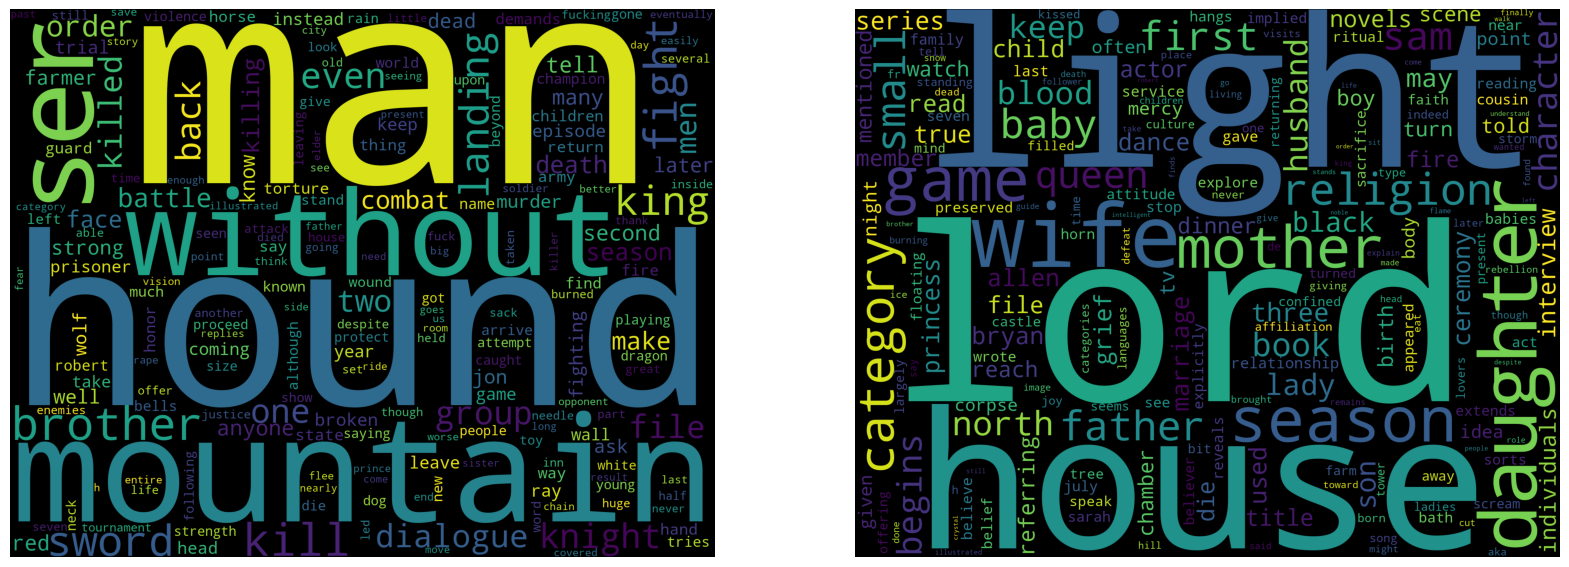

In [152]:
lowest_house_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_house_sentiment_str_weighted)


highest_house_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(highest_house_sentiment_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_house_sentiment_weighted_wordcloud)
ax[0].axis('off')

ax[1].imshow(highest_house_sentiment_weighted_wordcloud)
ax[1].axis('off')
plt.show()

In [153]:
dict_lowest_culture_TFTR_sentiment, dict_highest_culture_TFTR_sentiment, fdist_lowest_culture_sentiment, fdist_highest_culture_sentiment = get_TFTR(lowest_culture_raw, highest_culture_raw, c = 1, sentiment_words=dict_avg_sentiments)

dict_lowest_culture_TFTR_sentiment_weighted, dict_highest_culture_TFTR_sentiment_weighted, _, _ = get_TFTR(lowest_culture_raw, highest_culture_raw, c = 1, weighted=True, sentiment_words=dict_avg_sentiments)

min_lowest_culture_TFTR_sentiment = min(dict_lowest_culture_TFTR_sentiment.values())
min_highest_culture_TFTR_sentiment = min(dict_highest_culture_TFTR_sentiment.values())
min_lowest_culture_TFTR_sentiment_weighted = min(dict_lowest_culture_TFTR_sentiment_weighted.values())
min_highest_culture_TFTR_sentiment_weighted = min(dict_highest_culture_TFTR_sentiment_weighted.values())

print("Top 5 words in the text from the characters with lowest culture")
for i, w in enumerate(fdist_lowest_culture_sentiment):
    if i >= 10:
        break
    print(w, fdist_lowest_culture_sentiment[w])

print("\nTop 5 words in the text from the characters with highest culture")
for i, w in enumerate(fdist_highest_culture_sentiment):
    if i >= 10:
        break
    print(w, fdist_highest_culture_sentiment[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with lowest culture")
for i, w in enumerate(dict_lowest_culture_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_lowest_culture_TFTR_sentiment[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest culture")
for i, w in enumerate(dict_highest_culture_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_highest_culture_TFTR_sentiment[w])


print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest culture")
for i, w in enumerate(dict_lowest_culture_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_culture_TFTR_sentiment_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest culture")
for i, w in enumerate(dict_highest_culture_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_highest_culture_TFTR_sentiment_weighted[w])
    

Top 5 words in the text from the characters with lowest culture
mag 34
jon 30
weg 20
giants 20
wall 19
game 18
season 17
battle 16
giant 14
back 10

Top 5 words in the text from the characters with highest culture
house 139
season 109
file 91
game 89
king 84
high 58
queen 54
one 52
death 49
would 47

Top 5 TF-TR scores in the text from the characters with lowest culture
mag 1156.0
weg 400.0
giants 400.0
wall 361.0
jon 300.0
giant 196.0
mar 81.0
bastards 64.0
mighty 36.0
dar 36.0

Top 5 TF-TR scores in the text from the characters with highest culture
house 6440.333333333334
high 3364.0
queen 2916.0
would 2209.0
faith 2025.0
landing 1444.0
wedding 1225.0
sept 1225.0
file 1183.0
lord 1156.0

Top 5 weighted TF-TR scores in the text from the characters with lowest culture
mag 1156.0
jon 738.8609715242882
weg 400.0
giants 400.0
wall 361.0
giant 196.0
battle 101.32041274113952
mar 81.0
bastards 64.0
back 47.83646025376857

Top 5 weighted TF-TR scores in the text from the characters with high

In [154]:

lowest_culture_sentiment_str = ""
highest_culture_sentiment_str = ""

for w in dict_lowest_culture_TFTR_sentiment:
    for i in range(int(dict_lowest_culture_TFTR_sentiment[w]/min_lowest_culture_TFTR_sentiment)):
        lowest_culture_sentiment_str += w + " "

for w in dict_highest_culture_TFTR_sentiment:
    for i in range(int(dict_highest_culture_TFTR_sentiment[w]/min_highest_culture_TFTR_sentiment)):
        highest_culture_sentiment_str += w + " "

lowest_culture_sentiment_str_weighted = ""
highest_culture_sentiment_str_weighted = ""
for w in dict_lowest_culture_TFTR_sentiment_weighted:
    for i in range(int(dict_lowest_culture_TFTR_sentiment_weighted[w]/min_lowest_culture_TFTR_sentiment_weighted)):
        lowest_culture_sentiment_str_weighted += w + " "

for w in dict_highest_culture_TFTR_sentiment_weighted:
    for i in range(int(dict_highest_culture_TFTR_sentiment_weighted[w]/min_highest_culture_TFTR_sentiment_weighted)):
        highest_culture_sentiment_str_weighted += w + " "

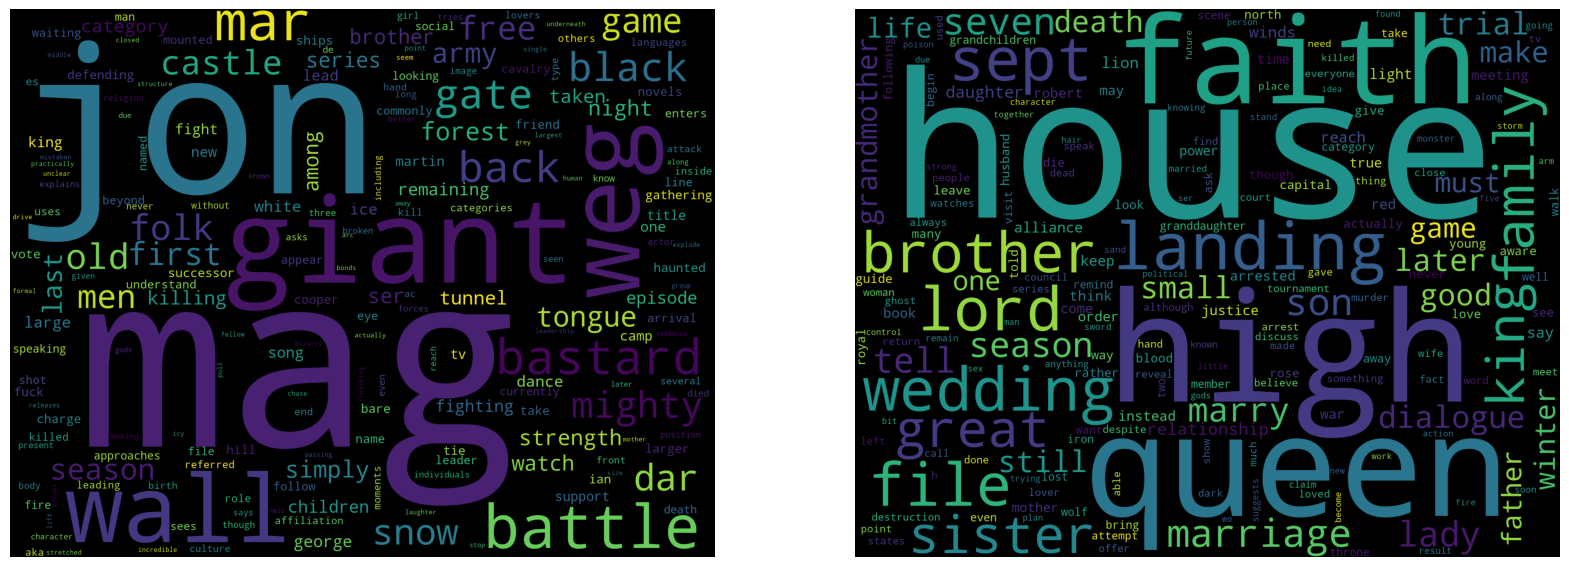

In [155]:
lowest_culture_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_culture_sentiment_str_weighted)


highest_culture_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(highest_culture_sentiment_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_culture_sentiment_weighted_wordcloud)
ax[0].axis('off')

ax[1].imshow(highest_culture_sentiment_weighted_wordcloud)
ax[1].axis('off')
plt.show()

In [156]:
dict_lowest_religion_TFTR_sentiment, dict_highest_religion_TFTR_sentiment, fdist_lowest_religion_sentiment, fdist_highest_religion_sentiment = get_TFTR(lowest_religion_raw, highest_religion_raw, c = 1, sentiment_words=dict_avg_sentiments)

dict_lowest_religion_TFTR_sentiment_weighted, dict_highest_religion_TFTR_sentiment_weighted, _, _ = get_TFTR(lowest_religion_raw, highest_religion_raw, c = 1, weighted=True, sentiment_words=dict_avg_sentiments)

min_lowest_religion_TFTR_sentiment = min(dict_lowest_culture_TFTR_sentiment.values())
min_highest_religion_TFTR_sentiment = min(dict_highest_culture_TFTR_sentiment.values())
min_lowest_religion_TFTR_sentiment_weighted = min(dict_lowest_culture_TFTR_sentiment_weighted.values())
min_highest_religion_TFTR_sentiment_weighted = min(dict_highest_culture_TFTR_sentiment_weighted.values())

print("Top 5 words in the text from the characters with lowest religion")
for i, w in enumerate(fdist_lowest_religion_sentiment):
    if i >= 10:
        break
    print(w, fdist_lowest_religion_sentiment[w])

print("\nTop 5 words in the text from the characters with highest religion")
for i, w in enumerate(fdist_highest_religion_sentiment):
    if i >= 10:
        break
    print(w, fdist_highest_religion_sentiment[w])
    

print("\nTop 5 TF-TR scores in the text from the characters with lowest religion")
for i, w in enumerate(dict_lowest_religion_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_lowest_religion_TFTR_sentiment[w])

print("\nTop 5 TF-TR scores in the text from the characters with highest religion")
for i, w in enumerate(dict_highest_religion_TFTR_sentiment):
    if i >= 10:
        break
    print(w, dict_highest_religion_TFTR_sentiment[w])


print("\nTop 5 weighted TF-TR scores in the text from the characters with lowest religion")
for i, w in enumerate(dict_lowest_religion_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_lowest_religion_TFTR_sentiment_weighted[w])

print("\nTop 5 weighted TF-TR scores in the text from the characters with highest religion")
for i, w in enumerate(dict_highest_religion_TFTR_sentiment_weighted):
    if i >= 10:
        break
    print(w, dict_highest_religion_TFTR_sentiment_weighted[w])
    

Top 5 words in the text from the characters with lowest religion
masters 61
season 46
mo 43
game 42
zo 34
sons 33
one 31
category 28
house 26
city 26

Top 5 words in the text from the characters with highest religion
season 145
jon 137
lord 123
game 120
king 109
file 104
light 102
house 91
one 83
battle 82

Top 5 TF-TR scores in the text from the characters with lowest religion
mo 1849.0
zo 1156.0
masters 744.1999999999999
pit 400.0
wise 176.33333333333334
slaves 81.0
grey 49.0
worm 49.0
city 45.06666666666667
fighting 44.1

Top 5 TF-TR scores in the text from the characters with highest religion
jon 18769.0
lord 15129.0
light 10404.0
red 3042.0
north 2916.0
king 2376.2000000000003
castle 2116.0
night 2048.0
brother 1936.0
robert 1925.3333333333333

Top 5 weighted TF-TR scores in the text from the characters with lowest religion
masters 1910.7250385947345
mo 1849.0
zo 1156.0
pit 400.0
wise 358.95699399018577
slaves 189.41041231236937
city 156.62654140858857
sons 142.68871570474943
figh

In [157]:
lowest_religion_sentiment_str = ""
highest_religion_sentiment_str = ""

for w in dict_lowest_religion_TFTR_sentiment:
    for i in range(int(dict_lowest_religion_TFTR_sentiment[w]/min_lowest_religion_TFTR_sentiment)):
        lowest_religion_sentiment_str += w + " "

for w in dict_highest_religion_TFTR_sentiment:
    for i in range(int(dict_highest_religion_TFTR_sentiment[w]/min_highest_religion_TFTR_sentiment)):
        highest_religion_sentiment_str += w + " "

lowest_religion_sentiment_str_weighted = ""
highest_religion_sentiment_str_weighted = ""
for w in dict_lowest_religion_TFTR_sentiment_weighted:
    for i in range(int(dict_lowest_religion_TFTR_sentiment_weighted[w]/min_lowest_religion_TFTR_sentiment_weighted)):
        lowest_religion_sentiment_str_weighted += w + " "

for w in dict_highest_religion_TFTR_sentiment_weighted:
    for i in range(int(dict_highest_religion_TFTR_sentiment_weighted[w]/min_highest_religion_TFTR_sentiment_weighted)):
        highest_religion_sentiment_str_weighted += w + " "

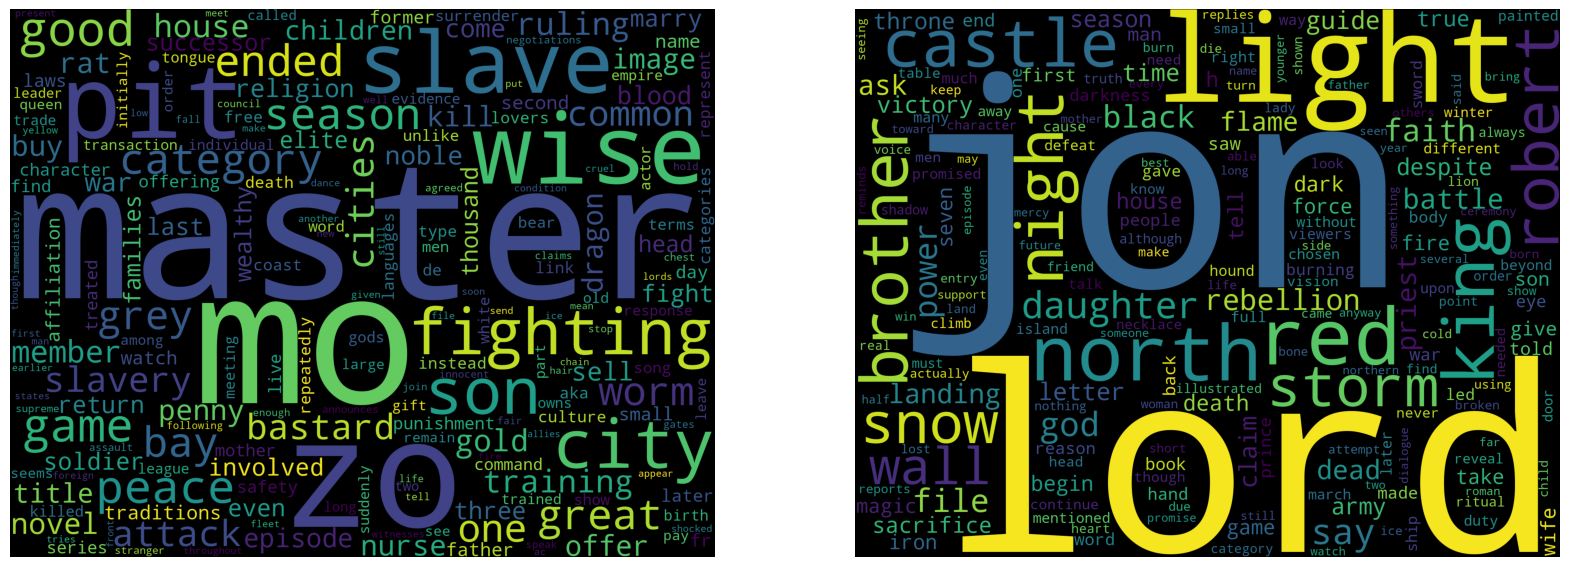

In [158]:
lowest_religion_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(lowest_religion_sentiment_str_weighted)


highest_religion_sentiment_weighted_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(highest_religion_sentiment_str_weighted)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lowest_religion_sentiment_weighted_wordcloud)
ax[0].axis('off')

ax[1].imshow(highest_religion_sentiment_weighted_wordcloud)
ax[1].axis('off')
plt.show()